In [1]:
import torch
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import optuna
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns


# trying to train the best possible baseline model for log loss

In [ ]:
#trying to train the best possible baseline model


class GCNNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, num_layers):
        super(GCNNet, self).__init__()
        self.layers = torch.nn.ModuleList()
        
        # First layer
        self.layers.append(GCNConv(num_features, hidden_channels))
        
        # Additional hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        
        # Final classification layer
        self.layers.append(GCNConv(hidden_channels, num_classes))
    
    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        
        # Final layer
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

def objective(trial):
    # Hyperparameter suggestions
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Prepare data
    dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
    data = dataset[0]
    
    # Split data
    num_classes = dataset.num_classes
    train_mask = data.train_mask
    val_mask = data.val_mask

    # Initialize model
    model = GCNNet(dataset.num_features, num_classes, hidden_channels, num_layers)
    
    # Choose optimizer
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        val_loss = F.nll_loss(out[val_mask], data.y[val_mask])
        
        # Multi-class evaluation on validation set
        y_true = data.y[val_mask].numpy()
        y_pred = pred[val_mask].numpy()
        
        # Compute F1 Score (macro)
        f1 = f1_score(y_true, y_pred, average='macro')
        
        # Compute Balanced Accuracy
        bacc = balanced_accuracy_score(y_true, y_pred)
        
        # Compute AUC-ROC (One-vs-Rest)
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_pred_proba = out[val_mask].softmax(dim=1).numpy()
        auc = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')

    return -f1  # Optuna minimizes, so we negate F1 score

def main():
    # Optuna study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value (Negative F1): {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Final model with best hyperparameters
    best_lr = trial.params['learning_rate']
    best_hidden = trial.params['hidden_channels']
    best_layers = trial.params['num_layers']
    best_optimizer_name = trial.params['optimizer']

    # Load full dataset
    dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
    data = dataset[0]
    num_classes = dataset.num_classes

    # Final model training
    final_model = GCNNet(dataset.num_features, num_classes, best_hidden, best_layers)
    
    if best_optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr)
    elif best_optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(final_model.parameters(), lr=best_lr)
    else:
        optimizer = torch.optim.SGD(final_model.parameters(), lr=best_lr)

    # Train on train + validation
    train_val_mask = data.train_mask | data.val_mask
    final_model.train()
    for epoch in range(300):
        optimizer.zero_grad()
        out = final_model(data.x, data.edge_index)
        loss = F.nll_loss(out[train_val_mask], data.y[train_val_mask])
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    final_model.eval()
    with torch.no_grad():
        out = final_model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        # Test set evaluation
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()
        
        # F1 Score per class
        f1_scores = f1_score(y_true, y_pred, average=None)
        
        # Balanced Accuracy per class
        bacc_scores = balanced_accuracy_score(y_true, y_pred)
        
        # AUC-ROC per class
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_pred_proba = out[data.test_mask].softmax(dim=1).numpy()
        auc_scores = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average=None)
        
        print("\nTest Set Results:")
        print("F1 Scores per Class:", f1_scores)
        print("Balanced Accuracy:", bacc_scores)
        print("AUC-ROC Scores per Class:", auc_scores)

if __name__ == "__main__":
    main()

[I 2024-12-08 18:41:41,644] A new study created in memory with name: no-name-96fa2970-b99a-45ab-9356-8a2ffeb42b35
/var/folders/mj/q6jnjfn542l3z311xtml52ph0000gn/T/ipykernel_58062/1976348361.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
Processing...
Done!
[I 2024-12-08 18:41:47,785] Trial 0 finished with value: -0.06819199166511061 and parameters: {'learning_rate': 0.001257340594696848, 'hidden_channels': 64, 'num_layers': 2, 'optimizer': 'SGD'}. Best is trial 0 with value: -0.06819199166511061.
/var/folders/mj/q6jnjfn542l3z311xtml52ph0000gn/T/ipykernel_58062/1976348361.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Best trial:
  Value (Negative F1): -0.7882483840559729
  Params: 
    learning_rate: 0.0005692473826048461
    hidden_channels: 128
    num_layers: 1
    optimizer: RMSprop

Test Set Results:
F1 Scores per Class: [0.7601476  0.85057471 0.90847458 0.88956127 0.88732394 0.83168317
 0.76106195]
Balanced Accuracy: 0.8272466742241557
AUC-ROC Scores per Class: [0.96036251 0.98405445 0.99348553 0.96628598 0.98392732 0.97869922
 0.983123  ]


# Using the best parameters to get lambda and lambda_klce

In [ ]:


def klce_loss(p_pred, p_target, baseline_loss, lambda_, lambda_klce):
    """
    KLCE Loss with weighted regularization terms.
    
    Args:
    p_pred: Predicted class probabilities.
    p_target: Target class distribution.
    baseline_loss: Cross-entropy or baseline loss.
    lambda_: Weight for baseline loss.
    lambda_klce: Weight for KLCE regularization.
    
    Returns:
    Combined loss value.
    """
    # Ensure p_target is broadcast to match p_pred's batch size
    p_target = p_target.unsqueeze(0).expand_as(p_pred)
    
    # Add small epsilon to prevent log(0)
    epsilon = 1e-8
    
    # KL Divergence term
    kl_divergence = torch.sum(p_pred * torch.log(p_pred / (p_target + epsilon)), dim=-1)
    
    # Cross-Entropy term
    cross_entropy = -torch.sum(p_target * torch.log(p_pred + epsilon), dim=-1)
    
    # Combined KLCE term
    klce = (lambda_klce * cross_entropy) + kl_divergence
    
    return baseline_loss + (lambda_ * (klce.mean()))

def calculate_target_distribution(data, num_classes):
    """
    Calculate the target class distribution (Pk).
    
    Args:
    data: Graph data object with labels.
    num_classes: Total number of classes.
    
    Returns:
    Normalized inverse class distribution.
    """
    # Get class counts in the training set
    _, class_counts = torch.unique(data.y[data.train_mask], return_counts=True)
    
    # Calculate class ratios
    class_ratios = class_counts / class_counts.sum()
    
    # Compute inverse ratios and normalize
    inverse_ratios = 1.0 / (class_ratios)
    p_k = inverse_ratios / inverse_ratios.sum()
    
    return p_k

class GCNNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, num_layers):
        super(GCNNet, self).__init__()
        self.layers = torch.nn.ModuleList()
        
        # First layer
        self.layers.append(GCNConv(num_features, hidden_channels))
        
        # Additional hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        
        # Final classification layer
        self.layers.append(GCNConv(hidden_channels, num_classes))
    
    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        
        # Final layer
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

def train_and_evaluate(model, data, optimizer, target_distribution, use_klce=False, 
                       lambda_=None, lambda_klce=None):
    """
    Train the model and evaluate performance.
    
    Args:
    model: GNN model
    data: Planetoid dataset
    optimizer: Optimizer
    target_distribution: Target class distribution
    use_klce: Whether to use KLCE loss
    lambda_, lambda_klce: KLCE loss hyperparameters
    
    Returns:
    Evaluation metrics
    """
    # Training
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        # Baseline loss
        baseline_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        
        # Compute loss
        if use_klce:
            loss = klce_loss(
                torch.exp(out[data.train_mask]),  # Convert log-softmax to probabilities
                target_distribution.to(out.device), 
                baseline_loss, 
                lambda_, 
                lambda_klce
            )
        else:
            loss = baseline_loss
        
        loss.backward()
        optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        # Test set metrics
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()
        
        # Compute metrics
        f1_macro = f1_score(y_true, y_pred, average='macro')
        bacc = balanced_accuracy_score(y_true, y_pred)
        
        # AUC-ROC (One-vs-Rest)
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        y_pred_proba = out[data.test_mask].softmax(dim=1).numpy()
        auc_macro = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')
        
        return {
            'f1_macro': f1_macro,
            'balanced_accuracy': bacc,
            'auc_macro': auc_macro
        }

def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    
    Args:
    trial: Optuna trial object
    
    Returns:
    Negative F1 score for minimization
    """
    # # Hyperparameters
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    # hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64, 128])
    # num_layers = trial.suggest_int('num_layers', 1, 3)
    #bets parametres from previous optuna run

    hidden_channels = 128
    learning_rate = 0.0005692473826048461
    num_layers= 1

    # KLCE loss hyperparameters
    lambda_ = trial.suggest_float("lambda", 0.0, 1.0)
    lambda_klce = trial.suggest_float("lambda_klce", -1.0, 1.0)
    
    # Prepare data
    dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
    data = dataset[0]
    
    # Calculate target distribution
    target_distribution = calculate_target_distribution(data, dataset.num_classes)
    
    # Initialize model
    model = GCNNet(dataset.num_features, dataset.num_classes, hidden_channels, num_layers)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # Train and evaluate with KLCE loss
    metrics_klce = train_and_evaluate(
        model, data, optimizer, target_distribution, 
        use_klce=True, lambda_=lambda_, lambda_klce=lambda_klce
    )
    
    return -metrics_klce['f1_macro']  # Optuna minimizes hence negative the whole score



[I 2024-12-08 19:05:52,181] A new study created in memory with name: no-name-22f8573a-fd9a-4054-8198-f2f56b963ad7
[I 2024-12-08 19:05:55,366] Trial 0 finished with value: -0.7906529720161727 and parameters: {'lambda': 0.7777851341905428, 'lambda_klce': 0.6809465326023751}. Best is trial 0 with value: -0.7906529720161727.
[I 2024-12-08 19:05:58,460] Trial 1 finished with value: -0.7981674758180837 and parameters: {'lambda': 0.9905551268399733, 'lambda_klce': 0.6368848223975743}. Best is trial 1 with value: -0.7981674758180837.
[I 2024-12-08 19:06:01,762] Trial 2 finished with value: -0.8004077880153636 and parameters: {'lambda': 0.8648211505981115, 'lambda_klce': 0.6783258577430613}. Best is trial 2 with value: -0.8004077880153636.
[I 2024-12-08 19:06:05,028] Trial 3 finished with value: -0.7975979784806269 and parameters: {'lambda': 0.33145206354207213, 'lambda_klce': 0.00634427330839471}. Best is trial 2 with value: -0.8004077880153636.
[I 2024-12-08 19:06:08,030] Trial 4 finished wit

Best KLCE Loss Hyperparameters:
lambda: 0.2110681088928853
lambda_klce: 0.18273733278267656

Model Performance Comparison:


NameError: name 'hidden_channels' is not defined

# calling the main function to compare the model performances

In [ ]:
def main():
    # Optuna study for hyperparameter optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    hidden_channels = 128
    learning_rate = 0.0005692473826048461
    num_layers= 1
    
    # Print best trial details
    print("Best KLCE Loss Hyperparameters:")
    trial = study.best_trial
    for key, value in trial.params.items():
        print(f"{key}: {value}")
    
    # Prepare dataset for final comparison
    dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())
    data = dataset[0]
    target_distribution = calculate_target_distribution(data, dataset.num_classes)
    
    # Best hyperparameters from study
    best_params = trial.params
    
    # Comparison of Log Loss vs KLCE Loss
    print("\nModel Performance Comparison:")
    
    # Log Loss Model
    log_loss_model = GCNNet(
        dataset.num_features, 
        dataset.num_classes, 
        hidden_channels, 
        num_layers
    )
    log_loss_optimizer = torch.optim.Adam(
        log_loss_model.parameters(), 
        learning_rate
    )
    log_loss_metrics = train_and_evaluate(
        log_loss_model, data, log_loss_optimizer, target_distribution, 
        use_klce=False
    )
    
    # KLCE Loss Model
    klce_loss_model = GCNNet(
        dataset.num_features, 
        dataset.num_classes, 
        hidden_channels, 
        num_layers
    )
    klce_loss_optimizer = torch.optim.Adam(
        klce_loss_model.parameters(), 
        lr=learning_rate
    )
    klce_loss_metrics = train_and_evaluate(
        klce_loss_model, data, klce_loss_optimizer, target_distribution, 
        use_klce=True, 
        lambda_=best_params['lambda'], 
        lambda_klce=best_params['lambda_klce']
    )
    
    # Print Comparison
    print("\nLog Loss Model Metrics:")
    for metric, value in log_loss_metrics.items():
        print(f"{metric}: {value}")
    
    print("\nKLCE Loss Model Metrics:")
    for metric, value in klce_loss_metrics.items():
        print(f"{metric}: {value}")

if __name__ == "__main__":
    main()

[I 2024-12-08 20:30:41,278] A new study created in memory with name: no-name-12836ee1-1b38-46f7-9045-70176c94046e
[I 2024-12-08 20:30:44,362] Trial 0 finished with value: -0.8009491327583681 and parameters: {'lambda': 0.5684780007830518, 'lambda_klce': 0.23332813239198047}. Best is trial 0 with value: -0.8009491327583681.
[I 2024-12-08 20:30:47,303] Trial 1 finished with value: -0.7953644221094335 and parameters: {'lambda': 0.9998466171920466, 'lambda_klce': 0.061985652840236716}. Best is trial 0 with value: -0.8009491327583681.
[I 2024-12-08 20:30:50,299] Trial 2 finished with value: -0.8002066438154084 and parameters: {'lambda': 0.7689789637714891, 'lambda_klce': 0.03000913192272825}. Best is trial 0 with value: -0.8009491327583681.
[I 2024-12-08 20:30:53,343] Trial 3 finished with value: -0.7966966628886646 and parameters: {'lambda': 0.8938318816935753, 'lambda_klce': -0.36117750434873064}. Best is trial 0 with value: -0.8009491327583681.
[I 2024-12-08 20:30:56,404] Trial 4 finished

Best KLCE Loss Hyperparameters:
lambda: 0.34998970084951386
lambda_klce: 0.18819110695519478

Model Performance Comparison:

Log Loss Model Metrics:
f1_macro: 0.7840999427788508
balanced_accuracy: 0.8050282193222511
auc_macro: 0.9680188343947742

KLCE Loss Model Metrics:
f1_macro: 0.7943640438422336
balanced_accuracy: 0.8162910932326453
auc_macro: 0.9671521994257797


In [ ]:


# Keep all the previous classes and functions the same as in the original code, 
# but modify the objective and main functions

def objective(trial, dataset, dataset_name, loss_type='klce'):
    # Grid search focused on lambda parameters
    lambda_ = trial.suggest_float("lambda", 0.0, 1.0)
    lambda_klce = trial.suggest_float("lambda_klce", -1.0, 1.0)
    
    # Fixed hyperparameters
    learning_rate = 0.0005692473826048461
    hidden_channels = 128
    num_layers = 1
    
    data = dataset[0]
    
    target_distribution = calculate_target_distribution(data, dataset.num_classes)
    
    # Create model with fixed hyperparameters
    model = GCNNet(dataset.num_features, dataset.num_classes, hidden_channels, num_layers)
    
    # Use RMSprop optimizer as specified
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    metrics = train_and_evaluate(
        model, data, optimizer, target_distribution, dataset.num_classes,
        dataset_name,
        loss_type=loss_type, 
        lambda_=lambda_, 
        lambda_klce=lambda_klce
    )
    
    # Handle potential None return from train_and_evaluate
    if metrics is None:
        return float('inf')  # Return a very high value to indicate failure
    
    return -metrics['f1_macro']

def main():
    dataset_names = ['Cora', 'PubMed', 'CiteSeer']
    
    # Create a results DataFrame with more columns for lambda parameters
    results_df = pd.DataFrame(columns=[
        'Dataset', 'Lambda', 'Lambda KLCE', 
        'F1 Macro', 'Balanced Accuracy', 'AUC Macro'
    ])
    
    best_params = {}
    
    for dataset_name in dataset_names:
        # Load dataset
        dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, transform=T.NormalizeFeatures())
        
        print(f"\n{'='*50}\nAnalyzing Dataset: {dataset_name}\n{'='*50}")
        
        # Perform grid search for lambda parameters
        study = optuna.create_study(direction='minimize')
        study.optimize(
            lambda trial: objective(trial, dataset, dataset_name, 'klce'), 
            n_trials=100,
            callbacks=[lambda study, trial: tqdm.write(f"Completed trial {trial.number} with value: {trial.value}")]
        )
        
        # Get best trial details
        trial = study.best_trial
        print("\nBest KLCE Loss Hyperparameters:")
        for key, value in trial.params.items():
            print(f"{key}: {value}")
            
        # Create model and optimizer with best lambda parameters
        best_model = GCNNet(
            dataset.num_features, 
            dataset.num_classes, 
            128,  # hidden_channels 
            1     # num_layers
        )
        
        optimizer = torch.optim.RMSprop(
            best_model.parameters(), 
            lr=0.0005692473826048461
        )
        
        target_distribution = calculate_target_distribution(dataset[0], dataset.num_classes)
        
        # Evaluate with best lambda parameters
        metrics = train_and_evaluate(
            best_model, dataset[0], optimizer, target_distribution, dataset.num_classes,
            dataset_name,
            loss_type='klce', 
            lambda_=trial.params['lambda'], 
            lambda_klce=trial.params['lambda_klce']
        )
        
        # Prepare results row
        results_row = {
            'Dataset': dataset_name,
            'Lambda': trial.params['lambda'],
            'Lambda KLCE': trial.params['lambda_klce'],
            'F1 Macro': metrics['f1_macro'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'AUC Macro': metrics['auc_macro']
        }
        results_df = results_df.append(results_row, ignore_index=True)
    
    # Save results
    os.makedirs('results', exist_ok=True)
    results_df.to_csv('results/lambda_grid_search_results.csv', index=False)
    
    print("\nFinal Performance Results:")
    print(results_df)

if __name__ == "__main__":
    main()

[I 2024-12-08 22:00:54,880] A new study created in memory with name: no-name-cb2b2c40-0d83-48d8-a88d-7b63c24f9696



Analyzing Dataset: Cora


[I 2024-12-08 22:00:58,208] Trial 0 finished with value: -0.8030531726553546 and parameters: {'lambda': 0.22024526731375993, 'lambda_klce': 0.289654420770425}. Best is trial 0 with value: -0.8030531726553546.


Completed trial 0 with value: -0.8030531726553546


[I 2024-12-08 22:01:01,353] Trial 1 finished with value: -0.8016671867210776 and parameters: {'lambda': 0.5962140264338653, 'lambda_klce': -0.6748663770873162}. Best is trial 0 with value: -0.8030531726553546.


Completed trial 1 with value: -0.8016671867210776


[I 2024-12-08 22:01:04,529] Trial 2 finished with value: -0.7964673889779706 and parameters: {'lambda': 0.08751181401110697, 'lambda_klce': -0.1215808181190825}. Best is trial 0 with value: -0.8030531726553546.


Completed trial 2 with value: -0.7964673889779706


[I 2024-12-08 22:01:07,919] Trial 3 finished with value: -0.7914986537442797 and parameters: {'lambda': 0.11388216156104314, 'lambda_klce': 0.2603507006591357}. Best is trial 0 with value: -0.8030531726553546.


Completed trial 3 with value: -0.7914986537442797


[I 2024-12-08 22:01:11,248] Trial 4 finished with value: -0.7951526630185192 and parameters: {'lambda': 0.8607417422283093, 'lambda_klce': 0.7745039084544096}. Best is trial 0 with value: -0.8030531726553546.


Completed trial 4 with value: -0.7951526630185192


[I 2024-12-08 22:01:14,434] Trial 5 finished with value: -0.8047035615684133 and parameters: {'lambda': 0.5287120257093824, 'lambda_klce': 0.6460819041421371}. Best is trial 5 with value: -0.8047035615684133.


Completed trial 5 with value: -0.8047035615684133


[I 2024-12-08 22:01:17,583] Trial 6 finished with value: -0.7878822131346132 and parameters: {'lambda': 0.8157411903395971, 'lambda_klce': 0.8373824469370323}. Best is trial 5 with value: -0.8047035615684133.


Completed trial 6 with value: -0.7878822131346132


[I 2024-12-08 22:01:20,685] Trial 7 finished with value: -0.7938390253610816 and parameters: {'lambda': 0.9323719162263657, 'lambda_klce': 0.8622211842149821}. Best is trial 5 with value: -0.8047035615684133.


Completed trial 7 with value: -0.7938390253610816


[I 2024-12-08 22:01:23,827] Trial 8 finished with value: -0.8048989326661985 and parameters: {'lambda': 0.016416541683420216, 'lambda_klce': 0.8540708644603474}. Best is trial 8 with value: -0.8048989326661985.


Completed trial 8 with value: -0.8048989326661985


[I 2024-12-08 22:01:26,989] Trial 9 finished with value: -0.7971387707420108 and parameters: {'lambda': 0.9612232425836682, 'lambda_klce': -0.5153744974292003}. Best is trial 8 with value: -0.8048989326661985.


Completed trial 9 with value: -0.7971387707420108


[I 2024-12-08 22:01:30,077] Trial 10 finished with value: -0.800505916331718 and parameters: {'lambda': 0.31882259207417835, 'lambda_klce': -0.21612100223339858}. Best is trial 8 with value: -0.8048989326661985.


Completed trial 10 with value: -0.800505916331718


[I 2024-12-08 22:01:33,212] Trial 11 finished with value: -0.8029935941703281 and parameters: {'lambda': 0.5395157624108311, 'lambda_klce': 0.5024814428212742}. Best is trial 8 with value: -0.8048989326661985.


Completed trial 11 with value: -0.8029935941703281


[I 2024-12-08 22:01:36,404] Trial 12 finished with value: -0.8063803599218423 and parameters: {'lambda': 0.4517560804953963, 'lambda_klce': 0.5067786168080761}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 12 with value: -0.8063803599218423


[I 2024-12-08 22:01:39,786] Trial 13 finished with value: -0.8014698058214426 and parameters: {'lambda': 0.3211702616168752, 'lambda_klce': 0.35337799710369033}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 13 with value: -0.8014698058214426


[I 2024-12-08 22:01:43,123] Trial 14 finished with value: -0.7931432046697819 and parameters: {'lambda': 0.7064588403964285, 'lambda_klce': -0.9731140083077803}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 14 with value: -0.7931432046697819


[I 2024-12-08 22:01:46,414] Trial 15 finished with value: -0.799131439034216 and parameters: {'lambda': 0.01795420223076128, 'lambda_klce': 0.959532664648674}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 15 with value: -0.799131439034216


[I 2024-12-08 22:01:49,652] Trial 16 finished with value: -0.7982560134803608 and parameters: {'lambda': 0.3542252014747524, 'lambda_klce': 0.07346923905229608}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 16 with value: -0.7982560134803608


[I 2024-12-08 22:01:52,966] Trial 17 finished with value: -0.7918189367747653 and parameters: {'lambda': 0.4169072453962587, 'lambda_klce': 0.5852920849149224}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 17 with value: -0.7918189367747653


[I 2024-12-08 22:01:56,260] Trial 18 finished with value: -0.8041597461177791 and parameters: {'lambda': 0.19813689883099828, 'lambda_klce': 0.06040174701769829}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 18 with value: -0.8041597461177791


[I 2024-12-08 22:01:59,681] Trial 19 finished with value: -0.8010341594614049 and parameters: {'lambda': 0.6764438080149754, 'lambda_klce': 0.9886571477646164}. Best is trial 12 with value: -0.8063803599218423.


Completed trial 19 with value: -0.8010341594614049


[I 2024-12-08 22:02:02,969] Trial 20 finished with value: -0.8067964073167898 and parameters: {'lambda': 0.4282691800429775, 'lambda_klce': 0.6763148372068257}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 20 with value: -0.8067964073167898


[I 2024-12-08 22:02:06,159] Trial 21 finished with value: -0.8016874118371317 and parameters: {'lambda': 0.22998810682704204, 'lambda_klce': 0.45923924001248606}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 21 with value: -0.8016874118371317


[I 2024-12-08 22:02:09,409] Trial 22 finished with value: -0.8024565130540721 and parameters: {'lambda': 0.4578756390291922, 'lambda_klce': 0.7001101317229538}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 22 with value: -0.8024565130540721


[I 2024-12-08 22:02:12,706] Trial 23 finished with value: -0.7979776197587282 and parameters: {'lambda': 0.4061206307895604, 'lambda_klce': 0.6679671799254858}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 23 with value: -0.7979776197587282


[I 2024-12-08 22:02:15,936] Trial 24 finished with value: -0.7982591347371191 and parameters: {'lambda': 0.6125749074783104, 'lambda_klce': 0.47620370551393765}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 24 with value: -0.7982591347371191


[I 2024-12-08 22:02:18,930] Trial 25 finished with value: -0.8051438185195432 and parameters: {'lambda': 0.0013700729881233609, 'lambda_klce': 0.23691874750919983}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 25 with value: -0.8051438185195432


[I 2024-12-08 22:02:21,913] Trial 26 finished with value: -0.7958064828387889 and parameters: {'lambda': 0.7532861669919639, 'lambda_klce': 0.20241749087699762}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 26 with value: -0.7958064828387889


[I 2024-12-08 22:02:25,111] Trial 27 finished with value: -0.7943477766505779 and parameters: {'lambda': 0.2668392111167358, 'lambda_klce': -0.2706776038952722}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 27 with value: -0.7943477766505779


[I 2024-12-08 22:02:28,151] Trial 28 finished with value: -0.8048631645302774 and parameters: {'lambda': 0.12441290024573834, 'lambda_klce': 0.14967545831793305}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 28 with value: -0.8048631645302774


[I 2024-12-08 22:02:31,198] Trial 29 finished with value: -0.7928867344145749 and parameters: {'lambda': 0.16934060706464454, 'lambda_klce': 0.36450593475272863}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 29 with value: -0.7928867344145749


[I 2024-12-08 22:02:34,574] Trial 30 finished with value: -0.799353952819733 and parameters: {'lambda': 0.47821673005637855, 'lambda_klce': -0.037867858611472516}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 30 with value: -0.799353952819733


[I 2024-12-08 22:02:37,639] Trial 31 finished with value: -0.8032277403479157 and parameters: {'lambda': 0.011329425849952168, 'lambda_klce': 0.5850110104419135}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 31 with value: -0.8032277403479157


[I 2024-12-08 22:02:40,935] Trial 32 finished with value: -0.8013819916170606 and parameters: {'lambda': 0.060649086377545194, 'lambda_klce': 0.7880164751218639}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 32 with value: -0.8013819916170606


[I 2024-12-08 22:02:44,208] Trial 33 finished with value: -0.8048491462536875 and parameters: {'lambda': 0.2747717003511657, 'lambda_klce': 0.3549018128816126}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 33 with value: -0.8048491462536875


[I 2024-12-08 22:02:47,584] Trial 34 finished with value: -0.8052258253016472 and parameters: {'lambda': 0.14928333229507706, 'lambda_klce': 0.5037872919130065}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 34 with value: -0.8052258253016472


[I 2024-12-08 22:02:50,923] Trial 35 finished with value: -0.7970254991103677 and parameters: {'lambda': 0.5925487876532158, 'lambda_klce': 0.2531050432570985}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 35 with value: -0.7970254991103677


[I 2024-12-08 22:02:54,549] Trial 36 finished with value: -0.8045955400492389 and parameters: {'lambda': 0.12772904090649734, 'lambda_klce': 0.48300445162866223}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 36 with value: -0.8045955400492389


[I 2024-12-08 22:02:57,958] Trial 37 finished with value: -0.8004765700639446 and parameters: {'lambda': 0.07980067592659751, 'lambda_klce': 0.38074867699269266}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 37 with value: -0.8004765700639446


[I 2024-12-08 22:03:01,422] Trial 38 finished with value: -0.8012113201189696 and parameters: {'lambda': 0.15442681761802524, 'lambda_klce': 0.5816399279227296}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 38 with value: -0.8012113201189696


[I 2024-12-08 22:03:04,792] Trial 39 finished with value: -0.8025232794533983 and parameters: {'lambda': 0.382178024701338, 'lambda_klce': 0.17099977185038012}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 39 with value: -0.8025232794533983


[I 2024-12-08 22:03:07,950] Trial 40 finished with value: -0.794800620736172 and parameters: {'lambda': 0.5425555036696303, 'lambda_klce': -0.12657800399290786}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 40 with value: -0.794800620736172


[I 2024-12-08 22:03:11,399] Trial 41 finished with value: -0.7938741116167823 and parameters: {'lambda': 0.048367092752622284, 'lambda_klce': 0.7338365861303207}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 41 with value: -0.7938741116167823


[I 2024-12-08 22:03:14,541] Trial 42 finished with value: -0.799999935992575 and parameters: {'lambda': 0.019874593493958717, 'lambda_klce': 0.8966409616443599}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 42 with value: -0.799999935992575


[I 2024-12-08 22:03:17,657] Trial 43 finished with value: -0.7969793581208195 and parameters: {'lambda': 0.08176089526083759, 'lambda_klce': 0.8426519989286332}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 43 with value: -0.7969793581208195


[I 2024-12-08 22:03:20,804] Trial 44 finished with value: -0.8009979395315477 and parameters: {'lambda': 0.19916376591547252, 'lambda_klce': 0.5515780222720097}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 44 with value: -0.8009979395315477


[I 2024-12-08 22:03:23,908] Trial 45 finished with value: -0.7984458850324586 and parameters: {'lambda': 0.0010781313840695639, 'lambda_klce': 0.6687219626674286}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 45 with value: -0.7984458850324586


[I 2024-12-08 22:03:27,069] Trial 46 finished with value: -0.8006883896087533 and parameters: {'lambda': 0.24605468479217285, 'lambda_klce': 0.796072394357836}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 46 with value: -0.8006883896087533


[I 2024-12-08 22:03:30,167] Trial 47 finished with value: -0.7999322888073735 and parameters: {'lambda': 0.3019076036622361, 'lambda_klce': 0.26807105718267266}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 47 with value: -0.7999322888073735


[I 2024-12-08 22:03:33,292] Trial 48 finished with value: -0.7902465593635667 and parameters: {'lambda': 0.15793049841200252, 'lambda_klce': 0.9211508793015004}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 48 with value: -0.7902465593635667


[I 2024-12-08 22:03:36,311] Trial 49 finished with value: -0.7887441006455526 and parameters: {'lambda': 0.8579871357055622, 'lambda_klce': 0.44807389490157645}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 49 with value: -0.7887441006455526


[I 2024-12-08 22:03:39,433] Trial 50 finished with value: -0.8028439397949672 and parameters: {'lambda': 0.44110146012658846, 'lambda_klce': -0.9301708049046553}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 50 with value: -0.8028439397949672


[I 2024-12-08 22:03:43,150] Trial 51 finished with value: -0.8019434497535824 and parameters: {'lambda': 0.12448835898127394, 'lambda_klce': 0.14238623073688447}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 51 with value: -0.8019434497535824


[I 2024-12-08 22:03:46,395] Trial 52 finished with value: -0.8007682701535693 and parameters: {'lambda': 0.10561609735094116, 'lambda_klce': 0.00846226096427316}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 52 with value: -0.8007682701535693


[I 2024-12-08 22:03:49,600] Trial 53 finished with value: -0.800407952434265 and parameters: {'lambda': 0.055229423001986855, 'lambda_klce': 0.09741669696311539}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 53 with value: -0.800407952434265


[I 2024-12-08 22:03:52,847] Trial 54 finished with value: -0.8040644754260876 and parameters: {'lambda': 0.5209696050538124, 'lambda_klce': 0.289028325350245}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 54 with value: -0.8040644754260876


[I 2024-12-08 22:03:55,972] Trial 55 finished with value: -0.8035387143534073 and parameters: {'lambda': 0.3403267273113825, 'lambda_klce': 0.7505715388847479}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 55 with value: -0.8035387143534073


[I 2024-12-08 22:03:59,041] Trial 56 finished with value: -0.7962381026316733 and parameters: {'lambda': 0.18944018487550948, 'lambda_klce': -0.27140710457588846}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 56 with value: -0.7962381026316733


[I 2024-12-08 22:04:02,093] Trial 57 finished with value: -0.7995665170516894 and parameters: {'lambda': 0.11587093815294829, 'lambda_klce': 0.41095919200507547}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 57 with value: -0.7995665170516894


[I 2024-12-08 22:04:05,216] Trial 58 finished with value: -0.8020709238322895 and parameters: {'lambda': 0.042455503882442625, 'lambda_klce': 0.5334770074498252}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 58 with value: -0.8020709238322895


[I 2024-12-08 22:04:08,381] Trial 59 finished with value: -0.8014378937935486 and parameters: {'lambda': 0.5987811720182348, 'lambda_klce': 0.6745449963943609}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 59 with value: -0.8014378937935486


[I 2024-12-08 22:04:11,482] Trial 60 finished with value: -0.8022181814712572 and parameters: {'lambda': 0.6527363533834591, 'lambda_klce': -0.483205467636305}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 60 with value: -0.8022181814712572


[I 2024-12-08 22:04:14,524] Trial 61 finished with value: -0.7979941999173968 and parameters: {'lambda': 0.4110065914775489, 'lambda_klce': 0.33114801739944255}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 61 with value: -0.7979941999173968


[I 2024-12-08 22:04:17,641] Trial 62 finished with value: -0.8001201089530586 and parameters: {'lambda': 0.26809581121622805, 'lambda_klce': 0.616036547663274}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 62 with value: -0.8001201089530586


[I 2024-12-08 22:04:20,668] Trial 63 finished with value: -0.7991519601589505 and parameters: {'lambda': 0.2967922631051569, 'lambda_klce': 0.4102059294545638}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 63 with value: -0.7991519601589505


[I 2024-12-08 22:04:23,714] Trial 64 finished with value: -0.795156804170526 and parameters: {'lambda': 0.2345327085133424, 'lambda_klce': 0.25729508911881316}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 64 with value: -0.795156804170526


[I 2024-12-08 22:04:26,747] Trial 65 finished with value: -0.7978567061208318 and parameters: {'lambda': 0.3649342802801384, 'lambda_klce': 0.20583413443541887}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 65 with value: -0.7978567061208318


[I 2024-12-08 22:04:29,777] Trial 66 finished with value: -0.8001339107081046 and parameters: {'lambda': 0.4891527675469787, 'lambda_klce': 0.3223866937646047}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 66 with value: -0.8001339107081046


[I 2024-12-08 22:04:32,851] Trial 67 finished with value: -0.7955707452880875 and parameters: {'lambda': 0.15544810656355976, 'lambda_klce': -0.09044622120534457}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 67 with value: -0.7955707452880875


[I 2024-12-08 22:04:35,865] Trial 68 finished with value: -0.8052202548756965 and parameters: {'lambda': 0.03670285672271795, 'lambda_klce': 0.5047262170783882}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 68 with value: -0.8052202548756965


[I 2024-12-08 22:04:38,952] Trial 69 finished with value: -0.7977057018485922 and parameters: {'lambda': 0.0840473900837658, 'lambda_klce': 0.49248233582460904}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 69 with value: -0.7977057018485922


[I 2024-12-08 22:04:41,975] Trial 70 finished with value: -0.7965836254687491 and parameters: {'lambda': 0.023835444733146458, 'lambda_klce': 0.6256773074484598}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 70 with value: -0.7965836254687491


[I 2024-12-08 22:04:45,050] Trial 71 finished with value: -0.7993894337702775 and parameters: {'lambda': 0.06441822377860099, 'lambda_klce': 0.5151735773967742}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 71 with value: -0.7993894337702775


[I 2024-12-08 22:04:48,031] Trial 72 finished with value: -0.7929916985478284 and parameters: {'lambda': 0.1299598007317963, 'lambda_klce': 0.43282503853775645}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 72 with value: -0.7929916985478284


[I 2024-12-08 22:04:51,026] Trial 73 finished with value: -0.7991507503283304 and parameters: {'lambda': 0.0013839024159960633, 'lambda_klce': 0.3750917718295843}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 73 with value: -0.7991507503283304


[I 2024-12-08 22:04:54,106] Trial 74 finished with value: -0.7930513001222852 and parameters: {'lambda': 0.09773292768557586, 'lambda_klce': 0.19980666500397126}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 74 with value: -0.7930513001222852


[I 2024-12-08 22:04:57,159] Trial 75 finished with value: -0.8041038087955614 and parameters: {'lambda': 0.44510108272674953, 'lambda_klce': 0.7070192244373587}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 75 with value: -0.8041038087955614


[I 2024-12-08 22:05:00,361] Trial 76 finished with value: -0.8046050795590384 and parameters: {'lambda': 0.19306887729567418, 'lambda_klce': 0.12660232592633225}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 76 with value: -0.8046050795590384


[I 2024-12-08 22:05:03,359] Trial 77 finished with value: -0.7976259488269288 and parameters: {'lambda': 0.043366601724311116, 'lambda_klce': 0.8064322207583874}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 77 with value: -0.7976259488269288


[I 2024-12-08 22:05:06,397] Trial 78 finished with value: -0.8048119598545803 and parameters: {'lambda': 0.3841504252941429, 'lambda_klce': 0.015695429254562465}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 78 with value: -0.8048119598545803


[I 2024-12-08 22:05:09,667] Trial 79 finished with value: -0.798793152040692 and parameters: {'lambda': 0.5643685677661101, 'lambda_klce': 0.5783197691897758}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 79 with value: -0.798793152040692


[I 2024-12-08 22:05:12,977] Trial 80 finished with value: -0.8042824067652352 and parameters: {'lambda': 0.26463687377953893, 'lambda_klce': 0.9271172979250017}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 80 with value: -0.8042824067652352


[I 2024-12-08 22:05:16,494] Trial 81 finished with value: -0.8031332148750229 and parameters: {'lambda': 0.3778310412590785, 'lambda_klce': 0.056240513298568426}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 81 with value: -0.8031332148750229


[I 2024-12-08 22:05:19,744] Trial 82 finished with value: -0.802204982624282 and parameters: {'lambda': 0.33183015233575935, 'lambda_klce': -0.019400297969414025}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 82 with value: -0.802204982624282


[I 2024-12-08 22:05:23,208] Trial 83 finished with value: -0.8001039687893907 and parameters: {'lambda': 0.505689407802735, 'lambda_klce': -0.16219116347918813}. Best is trial 20 with value: -0.8067964073167898.


Completed trial 83 with value: -0.8001039687893907


[I 2024-12-08 22:05:26,176] Trial 84 finished with value: -0.8071993094959325 and parameters: {'lambda': 0.41182205716450915, 'lambda_klce': 0.32091864544609666}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 84 with value: -0.8071993094959325


[I 2024-12-08 22:05:29,140] Trial 85 finished with value: -0.8008371679132879 and parameters: {'lambda': 0.024187574111602002, 'lambda_klce': 0.22140756750329188}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 85 with value: -0.8008371679132879


[I 2024-12-08 22:05:32,110] Trial 86 finished with value: -0.7968737877330749 and parameters: {'lambda': 0.08693883692480756, 'lambda_klce': 0.31589398587781503}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 86 with value: -0.7968737877330749


[I 2024-12-08 22:05:35,244] Trial 87 finished with value: -0.7970969261459261 and parameters: {'lambda': 0.4614395977292413, 'lambda_klce': 0.4587345401574551}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 87 with value: -0.7970969261459261


[I 2024-12-08 22:05:38,349] Trial 88 finished with value: -0.8033683786729162 and parameters: {'lambda': 0.4215741661516768, 'lambda_klce': 0.37442564115736376}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 88 with value: -0.8033683786729162


[I 2024-12-08 22:05:41,508] Trial 89 finished with value: -0.7930102756864014 and parameters: {'lambda': 0.21045658177589543, 'lambda_klce': 0.6402517536756864}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 89 with value: -0.7930102756864014


[I 2024-12-08 22:05:44,569] Trial 90 finished with value: -0.7896584408731371 and parameters: {'lambda': 0.981376548264531, 'lambda_klce': 0.9960154967928279}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 90 with value: -0.7896584408731371


[I 2024-12-08 22:05:47,571] Trial 91 finished with value: -0.8018448377581624 and parameters: {'lambda': 0.43019763175666925, 'lambda_klce': 0.05740626888337083}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 91 with value: -0.8018448377581624


[I 2024-12-08 22:05:50,526] Trial 92 finished with value: -0.8007972738178701 and parameters: {'lambda': 0.3962793298020856, 'lambda_klce': 0.5339312415929591}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 92 with value: -0.8007972738178701


[I 2024-12-08 22:05:53,512] Trial 93 finished with value: -0.7969490237861956 and parameters: {'lambda': 0.46222706149922466, 'lambda_klce': 0.8704751887037836}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 93 with value: -0.7969490237861956


[I 2024-12-08 22:05:56,458] Trial 94 finished with value: -0.8019891642827311 and parameters: {'lambda': 0.38774323925752846, 'lambda_klce': 0.1547374275776609}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 94 with value: -0.8019891642827311


[I 2024-12-08 22:05:59,516] Trial 95 finished with value: -0.8007962549477804 and parameters: {'lambda': 0.3075709205140438, 'lambda_klce': 0.30228447676198494}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 95 with value: -0.8007962549477804


[I 2024-12-08 22:06:02,765] Trial 96 finished with value: -0.8044511746805288 and parameters: {'lambda': 0.14093619395910725, 'lambda_klce': 0.2455665845212335}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 96 with value: -0.8044511746805288


[I 2024-12-08 22:06:05,786] Trial 97 finished with value: -0.7927653359380246 and parameters: {'lambda': 0.03520659325924157, 'lambda_klce': 0.7524312749064217}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 97 with value: -0.7927653359380246


[I 2024-12-08 22:06:08,698] Trial 98 finished with value: -0.7954813037389 and parameters: {'lambda': 0.06399735741938875, 'lambda_klce': 0.5709506594289118}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 98 with value: -0.7954813037389


[I 2024-12-08 22:06:11,692] Trial 99 finished with value: -0.7990262718304512 and parameters: {'lambda': 0.34565547192242224, 'lambda_klce': 0.0976742189615385}. Best is trial 84 with value: -0.8071993094959325.


Completed trial 99 with value: -0.7990262718304512

Best KLCE Loss Hyperparameters:
lambda: 0.41182205716450915
lambda_klce: 0.32091864544609666


/var/folders/mj/q6jnjfn542l3z311xtml52ph0000gn/T/ipykernel_58062/1768790865.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_row, ignore_index=True)
[I 2024-12-08 22:06:14,719] A new study created in memory with name: no-name-cefc985e-f46f-4b3e-b8fa-996586a72903



Analyzing Dataset: PubMed


[I 2024-12-08 22:06:31,727] Trial 0 finished with value: -0.7609983652361073 and parameters: {'lambda': 0.166406272694268, 'lambda_klce': -0.14458968526702676}. Best is trial 0 with value: -0.7609983652361073.


Completed trial 0 with value: -0.7609983652361073


[I 2024-12-08 22:06:48,338] Trial 1 finished with value: -0.7529112773297668 and parameters: {'lambda': 0.7357868546282217, 'lambda_klce': -0.6342988759420876}. Best is trial 0 with value: -0.7609983652361073.


Completed trial 1 with value: -0.7529112773297668


[I 2024-12-08 22:07:04,797] Trial 2 finished with value: -0.7715816392361868 and parameters: {'lambda': 0.4038732055859493, 'lambda_klce': 0.05320784195233408}. Best is trial 2 with value: -0.7715816392361868.


Completed trial 2 with value: -0.7715816392361868


[I 2024-12-08 22:07:22,084] Trial 3 finished with value: -0.7783112516568399 and parameters: {'lambda': 0.8197591378145811, 'lambda_klce': 0.6410198963232248}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 3 with value: -0.7783112516568399


[I 2024-12-08 22:07:39,447] Trial 4 finished with value: -0.7658868003655157 and parameters: {'lambda': 0.32118432576805467, 'lambda_klce': 0.06837472278167533}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 4 with value: -0.7658868003655157


[I 2024-12-08 22:07:56,955] Trial 5 finished with value: -0.7616226282157679 and parameters: {'lambda': 0.26033764150749894, 'lambda_klce': -0.5156355877041703}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 5 with value: -0.7616226282157679


[I 2024-12-08 22:08:13,970] Trial 6 finished with value: -0.7667591301678497 and parameters: {'lambda': 0.18643312580228233, 'lambda_klce': 0.12916287911815427}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 6 with value: -0.7667591301678497


[I 2024-12-08 22:08:31,580] Trial 7 finished with value: -0.774884534033743 and parameters: {'lambda': 0.4942972937781708, 'lambda_klce': 0.8395626940653043}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 7 with value: -0.774884534033743


[I 2024-12-08 22:08:48,642] Trial 8 finished with value: -0.7663642213729515 and parameters: {'lambda': 0.4882909896302411, 'lambda_klce': -0.17673554223162746}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 8 with value: -0.7663642213729515


[I 2024-12-08 22:09:06,111] Trial 9 finished with value: -0.7652876471432674 and parameters: {'lambda': 0.33501165843768466, 'lambda_klce': -0.18929379073845287}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 9 with value: -0.7652876471432674


[I 2024-12-08 22:09:23,335] Trial 10 finished with value: -0.7735305169546178 and parameters: {'lambda': 0.9862863692347064, 'lambda_klce': 0.9901237159912633}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 10 with value: -0.7735305169546178


[I 2024-12-08 22:09:40,306] Trial 11 finished with value: -0.7762768506775588 and parameters: {'lambda': 0.6725472675744516, 'lambda_klce': 0.8436421976791267}. Best is trial 3 with value: -0.7783112516568399.


Completed trial 11 with value: -0.7762768506775588


[I 2024-12-08 22:09:57,458] Trial 12 finished with value: -0.7794663134242085 and parameters: {'lambda': 0.732325622579048, 'lambda_klce': 0.4633701237689591}. Best is trial 12 with value: -0.7794663134242085.


Completed trial 12 with value: -0.7794663134242085


[I 2024-12-08 22:10:16,281] Trial 13 finished with value: -0.7758134127974988 and parameters: {'lambda': 0.8336061020339467, 'lambda_klce': 0.5080361833501171}. Best is trial 12 with value: -0.7794663134242085.


Completed trial 13 with value: -0.7758134127974988


[I 2024-12-08 22:10:34,832] Trial 14 finished with value: -0.7753731288921054 and parameters: {'lambda': 0.6569432454781466, 'lambda_klce': 0.4966547562084887}. Best is trial 12 with value: -0.7794663134242085.


Completed trial 14 with value: -0.7753731288921054


[I 2024-12-08 22:10:51,826] Trial 15 finished with value: -0.7762018147172364 and parameters: {'lambda': 0.9640942981607417, 'lambda_klce': 0.4795570406054889}. Best is trial 12 with value: -0.7794663134242085.


Completed trial 15 with value: -0.7762018147172364


[I 2024-12-08 22:11:09,124] Trial 16 finished with value: -0.718157369932397 and parameters: {'lambda': 0.844220510676249, 'lambda_klce': -0.9168208745702904}. Best is trial 12 with value: -0.7794663134242085.


Completed trial 16 with value: -0.718157369932397


[I 2024-12-08 22:11:27,218] Trial 17 finished with value: -0.7612493452111079 and parameters: {'lambda': 0.005296283422882575, 'lambda_klce': 0.31188847951260523}. Best is trial 12 with value: -0.7794663134242085.


Completed trial 17 with value: -0.7612493452111079


[I 2024-12-08 22:11:45,133] Trial 18 finished with value: -0.7803605418516216 and parameters: {'lambda': 0.605705507428619, 'lambda_klce': 0.6871188639401485}. Best is trial 18 with value: -0.7803605418516216.


Completed trial 18 with value: -0.7803605418516216


[I 2024-12-08 22:12:01,843] Trial 19 finished with value: -0.7720064449361765 and parameters: {'lambda': 0.6000400297681633, 'lambda_klce': 0.2925085587012948}. Best is trial 18 with value: -0.7803605418516216.


Completed trial 19 with value: -0.7720064449361765


[I 2024-12-08 22:12:18,664] Trial 20 finished with value: -0.7732136481184216 and parameters: {'lambda': 0.5727978790638988, 'lambda_klce': 0.7070573043117507}. Best is trial 18 with value: -0.7803605418516216.


Completed trial 20 with value: -0.7732136481184216


[I 2024-12-08 22:12:35,741] Trial 21 finished with value: -0.7805436685162777 and parameters: {'lambda': 0.7960499250842457, 'lambda_klce': 0.6636472983000609}. Best is trial 21 with value: -0.7805436685162777.


Completed trial 21 with value: -0.7805436685162777


[I 2024-12-08 22:12:52,185] Trial 22 finished with value: -0.7776991779326624 and parameters: {'lambda': 0.748798742985259, 'lambda_klce': 0.3354021779967697}. Best is trial 21 with value: -0.7805436685162777.


Completed trial 22 with value: -0.7776991779326624


[I 2024-12-08 22:13:08,891] Trial 23 finished with value: -0.7743254315432794 and parameters: {'lambda': 0.8933104709073145, 'lambda_klce': 0.6977574682944745}. Best is trial 21 with value: -0.7805436685162777.


Completed trial 23 with value: -0.7743254315432794


[I 2024-12-08 22:13:25,980] Trial 24 finished with value: -0.7814209671068447 and parameters: {'lambda': 0.7364648273356282, 'lambda_klce': 0.8717402755061665}. Best is trial 24 with value: -0.7814209671068447.


Completed trial 24 with value: -0.7814209671068447


[I 2024-12-08 22:13:43,453] Trial 25 finished with value: -0.7743800809942077 and parameters: {'lambda': 0.5799882731136987, 'lambda_klce': 0.9971260677880301}. Best is trial 24 with value: -0.7814209671068447.


Completed trial 25 with value: -0.7743800809942077


[I 2024-12-08 22:14:00,148] Trial 26 finished with value: -0.7755339865381298 and parameters: {'lambda': 0.6646462954870241, 'lambda_klce': 0.8151911977320692}. Best is trial 24 with value: -0.7814209671068447.


Completed trial 26 with value: -0.7755339865381298


[I 2024-12-08 22:14:16,730] Trial 27 finished with value: -0.7815878329884031 and parameters: {'lambda': 0.8979272996670761, 'lambda_klce': 0.6250735916957894}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 27 with value: -0.7815878329884031


[I 2024-12-08 22:14:33,666] Trial 28 finished with value: -0.7772739127267428 and parameters: {'lambda': 0.9047355906431024, 'lambda_klce': 0.8773513997350093}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 28 with value: -0.7772739127267428


[I 2024-12-08 22:14:50,167] Trial 29 finished with value: -0.7747991761753078 and parameters: {'lambda': 0.79056860067028, 'lambda_klce': 0.1880515395833246}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 29 with value: -0.7747991761753078


[I 2024-12-08 22:15:06,796] Trial 30 finished with value: -0.7718513353124455 and parameters: {'lambda': 0.9184253449356654, 'lambda_klce': 0.5927764730664093}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 30 with value: -0.7718513353124455


[I 2024-12-08 22:15:23,523] Trial 31 finished with value: -0.776867604214389 and parameters: {'lambda': 0.7104807952874581, 'lambda_klce': 0.7701208906508947}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 31 with value: -0.776867604214389


[I 2024-12-08 22:15:40,565] Trial 32 finished with value: -0.7802735038005442 and parameters: {'lambda': 0.7757072456722369, 'lambda_klce': 0.6000020897197236}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 32 with value: -0.7802735038005442


[I 2024-12-08 22:15:57,168] Trial 33 finished with value: -0.7727852611355536 and parameters: {'lambda': 0.8703069425378773, 'lambda_klce': -0.05555799228189984}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 33 with value: -0.7727852611355536


[I 2024-12-08 22:16:14,006] Trial 34 finished with value: -0.7609106841884473 and parameters: {'lambda': 0.6287831210909189, 'lambda_klce': -0.34108877002230553}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 34 with value: -0.7609106841884473


[I 2024-12-08 22:16:31,141] Trial 35 finished with value: -0.7710385940200518 and parameters: {'lambda': 0.5386334507665472, 'lambda_klce': 0.9309811292794952}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 35 with value: -0.7710385940200518


[I 2024-12-08 22:16:47,067] Trial 36 finished with value: -0.7775842006954482 and parameters: {'lambda': 0.7058863255433147, 'lambda_klce': 0.382533111858364}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 36 with value: -0.7775842006954482


[I 2024-12-08 22:17:03,802] Trial 37 finished with value: -0.7798813666890356 and parameters: {'lambda': 0.7842982876339183, 'lambda_klce': 0.7095148967322666}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 37 with value: -0.7798813666890356


[I 2024-12-08 22:17:20,113] Trial 38 finished with value: -0.7755843832891247 and parameters: {'lambda': 0.4606694178156256, 'lambda_klce': 0.6479782745839061}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 38 with value: -0.7755843832891247


[I 2024-12-08 22:17:35,572] Trial 39 finished with value: -0.7740573945458843 and parameters: {'lambda': 0.43357570022385655, 'lambda_klce': 0.5669234319384309}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 39 with value: -0.7740573945458843


[I 2024-12-08 22:17:50,968] Trial 40 finished with value: -0.775573469632528 and parameters: {'lambda': 0.8322459167553394, 'lambda_klce': 0.21398193100898605}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 40 with value: -0.775573469632528


[I 2024-12-08 22:18:07,267] Trial 41 finished with value: -0.7783780840237687 and parameters: {'lambda': 0.7700650264483357, 'lambda_klce': 0.7721850553192336}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 41 with value: -0.7783780840237687


[I 2024-12-08 22:18:23,106] Trial 42 finished with value: -0.7803210934442978 and parameters: {'lambda': 0.942478085773252, 'lambda_klce': 0.5952742254956601}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 42 with value: -0.7803210934442978


[I 2024-12-08 22:18:39,262] Trial 43 finished with value: -0.7768125940362626 and parameters: {'lambda': 0.9553855835515802, 'lambda_klce': 0.4231724036804331}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 43 with value: -0.7768125940362626


[I 2024-12-08 22:18:55,325] Trial 44 finished with value: -0.7719237511633228 and parameters: {'lambda': 0.958081516832437, 'lambda_klce': 0.9086994569610204}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 44 with value: -0.7719237511633228


[I 2024-12-08 22:19:11,390] Trial 45 finished with value: -0.7768984011789805 and parameters: {'lambda': 0.9270364120839893, 'lambda_klce': 0.7809290404442732}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 45 with value: -0.7768984011789805


[I 2024-12-08 22:19:26,651] Trial 46 finished with value: -0.7815078131833642 and parameters: {'lambda': 0.8709381807680447, 'lambda_klce': 0.5902593089535891}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 46 with value: -0.7815078131833642


[I 2024-12-08 22:19:42,037] Trial 47 finished with value: -0.7779962300378077 and parameters: {'lambda': 0.8775961800527906, 'lambda_klce': 0.026576199474854005}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 47 with value: -0.7779962300378077


[I 2024-12-08 22:19:57,381] Trial 48 finished with value: -0.7775969110191392 and parameters: {'lambda': 0.9938696651758412, 'lambda_klce': 0.5199228860111262}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 48 with value: -0.7775969110191392


[I 2024-12-08 22:20:12,639] Trial 49 finished with value: -0.7767800187737914 and parameters: {'lambda': 0.8151567164799143, 'lambda_klce': 0.6786686114499475}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 49 with value: -0.7767800187737914


[I 2024-12-08 22:20:28,301] Trial 50 finished with value: -0.7422592077609699 and parameters: {'lambda': 0.6923134483694539, 'lambda_klce': -0.6818781489913679}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 50 with value: -0.7422592077609699


[I 2024-12-08 22:20:43,681] Trial 51 finished with value: -0.7773642754593788 and parameters: {'lambda': 0.8571286844803223, 'lambda_klce': 0.6408723878989405}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 51 with value: -0.7773642754593788


[I 2024-12-08 22:20:58,938] Trial 52 finished with value: -0.7782106278119508 and parameters: {'lambda': 0.8117035339814421, 'lambda_klce': 0.567038383393017}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 52 with value: -0.7782106278119508


[I 2024-12-08 22:21:14,290] Trial 53 finished with value: -0.7735535089797563 and parameters: {'lambda': 0.931323569667565, 'lambda_klce': 0.9051505990618373}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 53 with value: -0.7735535089797563


[I 2024-12-08 22:21:29,609] Trial 54 finished with value: -0.7719348331767474 and parameters: {'lambda': 0.36296464659348826, 'lambda_klce': 0.43460188569544755}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 54 with value: -0.7719348331767474


[I 2024-12-08 22:21:44,890] Trial 55 finished with value: -0.7796643959227832 and parameters: {'lambda': 0.7387695876006608, 'lambda_klce': 0.732859300818693}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 55 with value: -0.7796643959227832


[I 2024-12-08 22:22:00,302] Trial 56 finished with value: -0.7722751014407471 and parameters: {'lambda': 0.5468377835883492, 'lambda_klce': 0.23410901312690702}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 56 with value: -0.7722751014407471


[I 2024-12-08 22:22:15,675] Trial 57 finished with value: -0.7788572127095938 and parameters: {'lambda': 0.8647449813785772, 'lambda_klce': 0.818862998205058}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 57 with value: -0.7788572127095938


[I 2024-12-08 22:22:30,965] Trial 58 finished with value: -0.7733078514109456 and parameters: {'lambda': 0.6435569151179152, 'lambda_klce': 0.3787943451587322}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 58 with value: -0.7733078514109456


[I 2024-12-08 22:22:46,227] Trial 59 finished with value: -0.7769550989842567 and parameters: {'lambda': 0.9991248588691123, 'lambda_klce': 0.5313305581161036}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 59 with value: -0.7769550989842567


[I 2024-12-08 22:23:01,505] Trial 60 finished with value: -0.7625452925173227 and parameters: {'lambda': 0.08893021255203204, 'lambda_klce': 0.6266067762306003}. Best is trial 27 with value: -0.7815878329884031.


Completed trial 60 with value: -0.7625452925173227


[I 2024-12-08 22:23:16,720] Trial 61 finished with value: -0.7829052316427854 and parameters: {'lambda': 0.7609003449800797, 'lambda_klce': 0.5923221980361978}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 61 with value: -0.7829052316427854


[I 2024-12-08 22:23:31,922] Trial 62 finished with value: -0.7800866371384965 and parameters: {'lambda': 0.6176378746818318, 'lambda_klce': 0.9574174175635015}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 62 with value: -0.7800866371384965


[I 2024-12-08 22:23:47,177] Trial 63 finished with value: -0.7712522886523585 and parameters: {'lambda': 0.7451775392881055, 'lambda_klce': 0.47137602870511497}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 63 with value: -0.7712522886523585


[I 2024-12-08 22:24:02,465] Trial 64 finished with value: -0.7777384910719967 and parameters: {'lambda': 0.8940334595639416, 'lambda_klce': 0.8712948766922918}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 64 with value: -0.7777384910719967


[I 2024-12-08 22:24:17,640] Trial 65 finished with value: -0.7726056181553563 and parameters: {'lambda': 0.7995065134320857, 'lambda_klce': 0.7434004540909718}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 65 with value: -0.7726056181553563


[I 2024-12-08 22:24:32,910] Trial 66 finished with value: -0.7685083522641514 and parameters: {'lambda': 0.2638962600090509, 'lambda_klce': 0.8264903547861072}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 66 with value: -0.7685083522641514


[I 2024-12-08 22:24:48,114] Trial 67 finished with value: -0.7763799095852016 and parameters: {'lambda': 0.6900777097307851, 'lambda_klce': 0.6712451752780879}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 67 with value: -0.7763799095852016


[I 2024-12-08 22:25:03,374] Trial 68 finished with value: -0.7758386107204139 and parameters: {'lambda': 0.8347215134597248, 'lambda_klce': 0.2932821922792906}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 68 with value: -0.7758386107204139


[I 2024-12-08 22:25:18,646] Trial 69 finished with value: -0.7784172786394885 and parameters: {'lambda': 0.7562754554295619, 'lambda_klce': 0.5514199921751399}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 69 with value: -0.7784172786394885


[I 2024-12-08 22:25:33,812] Trial 70 finished with value: -0.7696807346463789 and parameters: {'lambda': 0.7209099715669631, 'lambda_klce': 0.08175089293019233}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 70 with value: -0.7696807346463789


[I 2024-12-08 22:25:49,034] Trial 71 finished with value: -0.7805526889118221 and parameters: {'lambda': 0.7749396505981931, 'lambda_klce': 0.6012506276711306}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 71 with value: -0.7805526889118221


[I 2024-12-08 22:26:04,234] Trial 72 finished with value: -0.7774619327094484 and parameters: {'lambda': 0.9393665271973101, 'lambda_klce': 0.6224481089817546}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 72 with value: -0.7774619327094484


[I 2024-12-08 22:26:19,438] Trial 73 finished with value: -0.7802976877066062 and parameters: {'lambda': 0.8942561805633753, 'lambda_klce': 0.7211031764380277}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 73 with value: -0.7802976877066062


[I 2024-12-08 22:26:34,950] Trial 74 finished with value: -0.7780664519906323 and parameters: {'lambda': 0.8489145158998426, 'lambda_klce': 0.38799187453579}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 74 with value: -0.7780664519906323


[I 2024-12-08 22:26:50,209] Trial 75 finished with value: -0.7760533354031041 and parameters: {'lambda': 0.6601204768792254, 'lambda_klce': 0.46202316809247207}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 75 with value: -0.7760533354031041


[I 2024-12-08 22:27:05,454] Trial 76 finished with value: -0.7724008297756263 and parameters: {'lambda': 0.8004011962235547, 'lambda_klce': 0.79047613399934}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 76 with value: -0.7724008297756263


[I 2024-12-08 22:27:20,667] Trial 77 finished with value: -0.7605577796879821 and parameters: {'lambda': 0.7718304976762618, 'lambda_klce': -0.31205918777091035}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 77 with value: -0.7605577796879821


[I 2024-12-08 22:27:35,850] Trial 78 finished with value: -0.7740618012602632 and parameters: {'lambda': 0.902252052343852, 'lambda_klce': 0.588402521163285}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 78 with value: -0.7740618012602632


[I 2024-12-08 22:27:50,958] Trial 79 finished with value: -0.774655164168056 and parameters: {'lambda': 0.5150085700901899, 'lambda_klce': 0.6774347420213015}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 79 with value: -0.774655164168056


[I 2024-12-08 22:28:06,235] Trial 80 finished with value: -0.774883604825929 and parameters: {'lambda': 0.9676836613334062, 'lambda_klce': 0.5198866875031034}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 80 with value: -0.774883604825929


[I 2024-12-08 22:28:21,396] Trial 81 finished with value: -0.7730173777424317 and parameters: {'lambda': 0.8824957879895602, 'lambda_klce': 0.8664183884388159}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 81 with value: -0.7730173777424317


[I 2024-12-08 22:28:36,571] Trial 82 finished with value: -0.7768969158807811 and parameters: {'lambda': 0.8284441088674489, 'lambda_klce': 0.7336319163602246}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 82 with value: -0.7768969158807811


[I 2024-12-08 22:28:51,778] Trial 83 finished with value: -0.7723770343971527 and parameters: {'lambda': 0.9149321665331694, 'lambda_klce': 0.6996262252403276}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 83 with value: -0.7723770343971527


[I 2024-12-08 22:29:06,901] Trial 84 finished with value: -0.7773909789700042 and parameters: {'lambda': 0.8609793940114666, 'lambda_klce': 0.9552858299120887}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 84 with value: -0.7773909789700042


[I 2024-12-08 22:29:22,404] Trial 85 finished with value: -0.7758107110612659 and parameters: {'lambda': 0.967944925759669, 'lambda_klce': 0.5938277672714533}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 85 with value: -0.7758107110612659


[I 2024-12-08 22:29:38,582] Trial 86 finished with value: -0.7351498463222601 and parameters: {'lambda': 0.5916924575246023, 'lambda_klce': -0.9812615568233451}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 86 with value: -0.7351498463222601


[I 2024-12-08 22:29:54,020] Trial 87 finished with value: -0.7778912458433216 and parameters: {'lambda': 0.7188717944121188, 'lambda_klce': 0.7715666390566344}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 87 with value: -0.7778912458433216


[I 2024-12-08 22:30:09,633] Trial 88 finished with value: -0.7733928700659817 and parameters: {'lambda': 0.7635341708843905, 'lambda_klce': 0.6580363638244037}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 88 with value: -0.7733928700659817


[I 2024-12-08 22:30:25,545] Trial 89 finished with value: -0.7730590763309865 and parameters: {'lambda': 0.8825592796190692, 'lambda_klce': 0.9985127734080104}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 89 with value: -0.7730590763309865


[I 2024-12-08 22:30:41,352] Trial 90 finished with value: -0.7733443272841846 and parameters: {'lambda': 0.9454942733064132, 'lambda_klce': -0.040723220113281555}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 90 with value: -0.7733443272841846


[I 2024-12-08 22:30:56,923] Trial 91 finished with value: -0.7789793775290111 and parameters: {'lambda': 0.6875714210895247, 'lambda_klce': 0.6324788653414098}. Best is trial 61 with value: -0.7829052316427854.


Completed trial 91 with value: -0.7789793775290111


[I 2024-12-08 22:31:13,220] Trial 92 finished with value: -0.7843877015034173 and parameters: {'lambda': 0.7883666754473401, 'lambda_klce': 0.5958287784218629}. Best is trial 92 with value: -0.7843877015034173.


Completed trial 92 with value: -0.7843877015034173


[I 2024-12-08 22:31:29,332] Trial 93 finished with value: -0.7806383655162774 and parameters: {'lambda': 0.7894555823342163, 'lambda_klce': 0.5502192924363067}. Best is trial 92 with value: -0.7843877015034173.


Completed trial 93 with value: -0.7806383655162774


[I 2024-12-08 22:31:44,584] Trial 94 finished with value: -0.784618611763792 and parameters: {'lambda': 0.7829067644781432, 'lambda_klce': 0.4979266641111287}. Best is trial 94 with value: -0.784618611763792.


Completed trial 94 with value: -0.784618611763792


[I 2024-12-08 22:31:59,828] Trial 95 finished with value: -0.7782140647922783 and parameters: {'lambda': 0.7900397240494399, 'lambda_klce': 0.4285145521494901}. Best is trial 94 with value: -0.784618611763792.


Completed trial 95 with value: -0.7782140647922783


[I 2024-12-08 22:32:15,107] Trial 96 finished with value: -0.7753881673881674 and parameters: {'lambda': 0.7493006850542389, 'lambda_klce': 0.3349062402947141}. Best is trial 94 with value: -0.784618611763792.


Completed trial 96 with value: -0.7753881673881674


[I 2024-12-08 22:32:30,415] Trial 97 finished with value: -0.7819933972803411 and parameters: {'lambda': 0.8142358627434335, 'lambda_klce': 0.5026931088757886}. Best is trial 94 with value: -0.784618611763792.


Completed trial 97 with value: -0.7819933972803411


[I 2024-12-08 22:32:45,682] Trial 98 finished with value: -0.7817560828540252 and parameters: {'lambda': 0.8212788538168018, 'lambda_klce': 0.4943003011100464}. Best is trial 94 with value: -0.784618611763792.


Completed trial 98 with value: -0.7817560828540252


[I 2024-12-08 22:33:00,860] Trial 99 finished with value: -0.7779054861905282 and parameters: {'lambda': 0.8196188874215153, 'lambda_klce': 0.49694418117301453}. Best is trial 94 with value: -0.784618611763792.


Completed trial 99 with value: -0.7779054861905282

Best KLCE Loss Hyperparameters:
lambda: 0.7829067644781432
lambda_klce: 0.4979266641111287


/var/folders/mj/q6jnjfn542l3z311xtml52ph0000gn/T/ipykernel_58062/1768790865.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_row, ignore_index=True)
Processing...
Done!
[I 2024-12-08 22:33:18,427] A new study created in memory with name: no-name-86ed5cdf-1e62-48f7-b418-7c4ca14f08c8



Analyzing Dataset: CiteSeer


[I 2024-12-08 22:33:21,899] Trial 0 finished with value: -0.6457955194023931 and parameters: {'lambda': 0.6022139303724588, 'lambda_klce': 0.250909430386673}. Best is trial 0 with value: -0.6457955194023931.


Completed trial 0 with value: -0.6457955194023931


[I 2024-12-08 22:33:25,452] Trial 1 finished with value: -0.6371072486605899 and parameters: {'lambda': 0.8823034879517685, 'lambda_klce': -0.3221266853712619}. Best is trial 0 with value: -0.6457955194023931.


Completed trial 1 with value: -0.6371072486605899


[I 2024-12-08 22:33:28,997] Trial 2 finished with value: -0.6531879901956872 and parameters: {'lambda': 0.35308759042143434, 'lambda_klce': -0.9162312421336054}. Best is trial 2 with value: -0.6531879901956872.


Completed trial 2 with value: -0.6531879901956872


[I 2024-12-08 22:33:32,594] Trial 3 finished with value: -0.6616931616564058 and parameters: {'lambda': 0.41423709494210714, 'lambda_klce': -0.31555392617688316}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 3 with value: -0.6616931616564058


[I 2024-12-08 22:33:36,216] Trial 4 finished with value: -0.6514613269500789 and parameters: {'lambda': 0.7415091600230973, 'lambda_klce': -0.3411366468482655}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 4 with value: -0.6514613269500789


[I 2024-12-08 22:33:39,682] Trial 5 finished with value: -0.6527874832664603 and parameters: {'lambda': 0.359730667958837, 'lambda_klce': -0.27042746647987137}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 5 with value: -0.6527874832664603


[I 2024-12-08 22:33:43,103] Trial 6 finished with value: -0.6486998534368847 and parameters: {'lambda': 0.8208321171646287, 'lambda_klce': -0.24580149200668}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 6 with value: -0.6486998534368847


[I 2024-12-08 22:33:46,556] Trial 7 finished with value: -0.6411831621239592 and parameters: {'lambda': 0.8996957351672561, 'lambda_klce': -0.5512265348941894}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 7 with value: -0.6411831621239592


[I 2024-12-08 22:33:50,045] Trial 8 finished with value: -0.6497900767516941 and parameters: {'lambda': 0.26458558439788105, 'lambda_klce': 0.9370770551838483}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 8 with value: -0.6497900767516941


[I 2024-12-08 22:33:53,288] Trial 9 finished with value: -0.6509941585491986 and parameters: {'lambda': 0.19867817055396575, 'lambda_klce': 0.8944863032386652}. Best is trial 3 with value: -0.6616931616564058.


Completed trial 9 with value: -0.6509941585491986


[I 2024-12-08 22:33:56,576] Trial 10 finished with value: -0.6622865017463608 and parameters: {'lambda': 0.05316382852299206, 'lambda_klce': 0.33860537840440474}. Best is trial 10 with value: -0.6622865017463608.


Completed trial 10 with value: -0.6622865017463608


[I 2024-12-08 22:33:59,959] Trial 11 finished with value: -0.6629731883868998 and parameters: {'lambda': 0.01292556610388551, 'lambda_klce': 0.32309749540887045}. Best is trial 11 with value: -0.6629731883868998.


Completed trial 11 with value: -0.6629731883868998


[I 2024-12-08 22:34:03,308] Trial 12 finished with value: -0.6593849924959634 and parameters: {'lambda': 0.010981994547602382, 'lambda_klce': 0.355499078234751}. Best is trial 11 with value: -0.6629731883868998.


Completed trial 12 with value: -0.6593849924959634


[I 2024-12-08 22:34:06,762] Trial 13 finished with value: -0.6576692490966453 and parameters: {'lambda': 0.0274200245176438, 'lambda_klce': 0.4991444354141304}. Best is trial 11 with value: -0.6629731883868998.


Completed trial 13 with value: -0.6576692490966453


[I 2024-12-08 22:34:10,152] Trial 14 finished with value: -0.6516049405022156 and parameters: {'lambda': 0.12100852783402487, 'lambda_klce': 0.6357380950931281}. Best is trial 11 with value: -0.6629731883868998.


Completed trial 14 with value: -0.6516049405022156


[I 2024-12-08 22:34:13,930] Trial 15 finished with value: -0.6500609576801776 and parameters: {'lambda': 0.14302927870095886, 'lambda_klce': 0.07800268035728025}. Best is trial 11 with value: -0.6629731883868998.


Completed trial 15 with value: -0.6500609576801776


[I 2024-12-08 22:34:17,365] Trial 16 finished with value: -0.6505883098145063 and parameters: {'lambda': 0.5520089338314726, 'lambda_klce': 0.057060264201296174}. Best is trial 11 with value: -0.6629731883868998.


Completed trial 16 with value: -0.6505883098145063


[I 2024-12-08 22:34:20,857] Trial 17 finished with value: -0.6726710006630522 and parameters: {'lambda': 0.006151086207367956, 'lambda_klce': 0.6960840073170451}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 17 with value: -0.6726710006630522


[I 2024-12-08 22:34:24,340] Trial 18 finished with value: -0.651456833820161 and parameters: {'lambda': 0.24210843277269756, 'lambda_klce': 0.680656994834095}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 18 with value: -0.651456833820161


[I 2024-12-08 22:34:27,688] Trial 19 finished with value: -0.6447932711129754 and parameters: {'lambda': 0.6935606720474896, 'lambda_klce': 0.6999213060879632}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 19 with value: -0.6447932711129754


[I 2024-12-08 22:34:31,115] Trial 20 finished with value: -0.6498108997425548 and parameters: {'lambda': 0.45781922556125737, 'lambda_klce': 0.9984763499549323}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 20 with value: -0.6498108997425548


[I 2024-12-08 22:34:34,467] Trial 21 finished with value: -0.6487172836703184 and parameters: {'lambda': 0.10368510474770085, 'lambda_klce': 0.29813242994839173}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 21 with value: -0.6487172836703184


[I 2024-12-08 22:34:37,753] Trial 22 finished with value: -0.6535035964090933 and parameters: {'lambda': 0.002861074242140934, 'lambda_klce': 0.45247677399608166}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 22 with value: -0.6535035964090933


[I 2024-12-08 22:34:41,128] Trial 23 finished with value: -0.6495455623370051 and parameters: {'lambda': 0.0976523764962223, 'lambda_klce': 0.15750028137510783}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 23 with value: -0.6495455623370051


[I 2024-12-08 22:34:44,439] Trial 24 finished with value: -0.656816475349636 and parameters: {'lambda': 0.2752210748635798, 'lambda_klce': 0.579548478815886}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 24 with value: -0.656816475349636


[I 2024-12-08 22:34:47,753] Trial 25 finished with value: -0.659107981840919 and parameters: {'lambda': 0.19038439753730216, 'lambda_klce': -0.06941593524724365}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 25 with value: -0.659107981840919


[I 2024-12-08 22:34:51,048] Trial 26 finished with value: -0.6597410167460768 and parameters: {'lambda': 0.07210153823476154, 'lambda_klce': 0.8433657221779374}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 26 with value: -0.6597410167460768


[I 2024-12-08 22:34:54,382] Trial 27 finished with value: -0.6535192141599722 and parameters: {'lambda': 0.15009761576003142, 'lambda_klce': -0.11036776577037821}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 27 with value: -0.6535192141599722


[I 2024-12-08 22:34:57,925] Trial 28 finished with value: -0.6603934740149208 and parameters: {'lambda': 0.324164650928959, 'lambda_klce': 0.40697933979808526}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 28 with value: -0.6603934740149208


[I 2024-12-08 22:35:01,240] Trial 29 finished with value: -0.6575179889648357 and parameters: {'lambda': 0.06122581148593275, 'lambda_klce': 0.22177765984232428}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 29 with value: -0.6575179889648357


[I 2024-12-08 22:35:04,571] Trial 30 finished with value: -0.649403500486924 and parameters: {'lambda': 0.1586134092470757, 'lambda_klce': 0.2369943167161646}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 30 with value: -0.649403500486924


[I 2024-12-08 22:35:07,910] Trial 31 finished with value: -0.6583249449915954 and parameters: {'lambda': 0.43997658066283774, 'lambda_klce': -0.5108614678869465}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 31 with value: -0.6583249449915954


[I 2024-12-08 22:35:11,172] Trial 32 finished with value: -0.6365236971359902 and parameters: {'lambda': 0.6065600089497228, 'lambda_klce': 0.7804883354768306}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 32 with value: -0.6365236971359902


[I 2024-12-08 22:35:14,594] Trial 33 finished with value: -0.6610170581351948 and parameters: {'lambda': 0.055180305292566484, 'lambda_klce': -0.8058459338516284}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 33 with value: -0.6610170581351948


[I 2024-12-08 22:35:17,932] Trial 34 finished with value: -0.649620533239127 and parameters: {'lambda': 0.40819919347035416, 'lambda_klce': -0.5045883163425504}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 34 with value: -0.649620533239127


[I 2024-12-08 22:35:21,291] Trial 35 finished with value: -0.662824031263113 and parameters: {'lambda': 0.22305957068852553, 'lambda_klce': -0.13353516574696012}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 35 with value: -0.662824031263113


[I 2024-12-08 22:35:24,634] Trial 36 finished with value: -0.6646105605688287 and parameters: {'lambda': 7.182165624163711e-05, 'lambda_klce': -0.12944302239257655}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 36 with value: -0.6646105605688287


[I 2024-12-08 22:35:28,015] Trial 37 finished with value: -0.6397624621426533 and parameters: {'lambda': 0.9948161149077059, 'lambda_klce': -0.1606851456446854}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 37 with value: -0.6397624621426533


[I 2024-12-08 22:35:31,331] Trial 38 finished with value: -0.6526132207386452 and parameters: {'lambda': 0.21442920341373264, 'lambda_klce': -0.010731242764956114}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 38 with value: -0.6526132207386452


[I 2024-12-08 22:35:34,688] Trial 39 finished with value: -0.6486161427054237 and parameters: {'lambda': 0.3102972321236247, 'lambda_klce': -0.19754198061897477}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 39 with value: -0.6486161427054237


[I 2024-12-08 22:35:37,988] Trial 40 finished with value: -0.6552976430748451 and parameters: {'lambda': 0.004892827142090546, 'lambda_klce': -0.4021509141080985}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 40 with value: -0.6552976430748451


[I 2024-12-08 22:35:41,313] Trial 41 finished with value: -0.6679736094200676 and parameters: {'lambda': 0.07696930245987316, 'lambda_klce': 0.09517502332160355}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 41 with value: -0.6679736094200676


[I 2024-12-08 22:35:44,619] Trial 42 finished with value: -0.6565328745901475 and parameters: {'lambda': 0.098286151156741, 'lambda_klce': 0.11104132275194223}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 42 with value: -0.6565328745901475


[I 2024-12-08 22:35:47,929] Trial 43 finished with value: -0.6584044687287084 and parameters: {'lambda': 0.0586102294807733, 'lambda_klce': -0.02965259498889375}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 43 with value: -0.6584044687287084


[I 2024-12-08 22:35:51,300] Trial 44 finished with value: -0.6496391116282297 and parameters: {'lambda': 0.17787544399828106, 'lambda_klce': 0.16647329299904645}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 44 with value: -0.6496391116282297


[I 2024-12-08 22:35:54,690] Trial 45 finished with value: -0.660144959804147 and parameters: {'lambda': 0.13041563035319875, 'lambda_klce': -0.28328471690345236}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 45 with value: -0.660144959804147


[I 2024-12-08 22:35:58,095] Trial 46 finished with value: -0.6559431773945098 and parameters: {'lambda': 0.041598248418962994, 'lambda_klce': -0.3853637611888753}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 46 with value: -0.6559431773945098


[I 2024-12-08 22:36:01,509] Trial 47 finished with value: -0.6542999033492521 and parameters: {'lambda': 0.24126341765222323, 'lambda_klce': 0.5735551251846872}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 47 with value: -0.6542999033492521


[I 2024-12-08 22:36:05,040] Trial 48 finished with value: -0.6628185756291732 and parameters: {'lambda': 0.002407925449845655, 'lambda_klce': 0.048142512920022945}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 48 with value: -0.6628185756291732


[I 2024-12-08 22:36:08,877] Trial 49 finished with value: -0.6613918932802118 and parameters: {'lambda': 0.10011028943889339, 'lambda_klce': -0.1518873099421958}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 49 with value: -0.6613918932802118


[I 2024-12-08 22:36:12,563] Trial 50 finished with value: -0.6465864416342791 and parameters: {'lambda': 0.201749719492819, 'lambda_klce': -0.6110050285548103}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 50 with value: -0.6465864416342791


[I 2024-12-08 22:36:16,157] Trial 51 finished with value: -0.6633371423262054 and parameters: {'lambda': 0.009414012734565727, 'lambda_klce': 0.0449032417845051}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 51 with value: -0.6633371423262054


[I 2024-12-08 22:36:19,713] Trial 52 finished with value: -0.6526963564707732 and parameters: {'lambda': 0.05149912702362115, 'lambda_klce': 0.0043478832863769745}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 52 with value: -0.6526963564707732


[I 2024-12-08 22:36:23,098] Trial 53 finished with value: -0.6527580278917932 and parameters: {'lambda': 0.08410734411662842, 'lambda_klce': -0.23406321513178774}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 53 with value: -0.6527580278917932


[I 2024-12-08 22:36:26,397] Trial 54 finished with value: -0.658553339927904 and parameters: {'lambda': 0.029302927429075885, 'lambda_klce': 0.2829295610133063}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 54 with value: -0.658553339927904


[I 2024-12-08 22:36:29,692] Trial 55 finished with value: -0.6478329223062091 and parameters: {'lambda': 0.13644402121213112, 'lambda_klce': 0.3740879885556755}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 55 with value: -0.6478329223062091


[I 2024-12-08 22:36:33,010] Trial 56 finished with value: -0.6660750562549207 and parameters: {'lambda': 0.005151635469162575, 'lambda_klce': -0.09774748601849237}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 56 with value: -0.6660750562549207


[I 2024-12-08 22:36:36,429] Trial 57 finished with value: -0.6662476812637168 and parameters: {'lambda': 0.04435373258720572, 'lambda_klce': 0.17797315694611124}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 57 with value: -0.6662476812637168


[I 2024-12-08 22:36:39,710] Trial 58 finished with value: -0.6529587406808423 and parameters: {'lambda': 0.028281110362687878, 'lambda_klce': 0.1719263092844111}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 58 with value: -0.6529587406808423


[I 2024-12-08 22:36:43,047] Trial 59 finished with value: -0.6486435004017651 and parameters: {'lambda': 0.7694349428844681, 'lambda_klce': -0.07402711993335728}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 59 with value: -0.6486435004017651


[I 2024-12-08 22:36:46,405] Trial 60 finished with value: -0.6620092296143804 and parameters: {'lambda': 0.1238006748392942, 'lambda_klce': 0.10676663906401752}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 60 with value: -0.6620092296143804


[I 2024-12-08 22:36:49,806] Trial 61 finished with value: -0.6520654045654046 and parameters: {'lambda': 0.08169582453542712, 'lambda_klce': 0.031508317389058016}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 61 with value: -0.6520654045654046


[I 2024-12-08 22:36:53,143] Trial 62 finished with value: -0.6540051230747813 and parameters: {'lambda': 0.0013378316697697998, 'lambda_klce': 0.3139437206862309}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 62 with value: -0.6540051230747813


[I 2024-12-08 22:36:56,454] Trial 63 finished with value: -0.6673739545482982 and parameters: {'lambda': 0.036814254553412945, 'lambda_klce': 0.5411425139921926}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 63 with value: -0.6673739545482982


[I 2024-12-08 22:36:59,918] Trial 64 finished with value: -0.6583034523267075 and parameters: {'lambda': 0.16580078565314904, 'lambda_klce': 0.48173317054122083}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 64 with value: -0.6583034523267075


[I 2024-12-08 22:37:03,266] Trial 65 finished with value: -0.6593006690837359 and parameters: {'lambda': 0.04779258832955997, 'lambda_klce': 0.8138255613776852}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 65 with value: -0.6593006690837359


[I 2024-12-08 22:37:06,835] Trial 66 finished with value: -0.6573978242015123 and parameters: {'lambda': 0.08194889941048228, 'lambda_klce': 0.7459353785813609}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 66 with value: -0.6573978242015123


[I 2024-12-08 22:37:10,240] Trial 67 finished with value: -0.6614731813126657 and parameters: {'lambda': 0.035708038664557004, 'lambda_klce': 0.5478551725318204}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 67 with value: -0.6614731813126657


[I 2024-12-08 22:37:13,774] Trial 68 finished with value: -0.663288190685739 and parameters: {'lambda': 0.11519588708396698, 'lambda_klce': 0.6516807910862266}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 68 with value: -0.663288190685739


[I 2024-12-08 22:37:17,373] Trial 69 finished with value: -0.6512385246613582 and parameters: {'lambda': 0.6280908577549704, 'lambda_klce': 0.22287716044426617}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 69 with value: -0.6512385246613582


[I 2024-12-08 22:37:20,760] Trial 70 finished with value: -0.6537180855960049 and parameters: {'lambda': 0.07650441901197605, 'lambda_klce': -0.3418115097023634}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 70 with value: -0.6537180855960049


[I 2024-12-08 22:37:24,193] Trial 71 finished with value: -0.6628354475483691 and parameters: {'lambda': 0.1079147463240997, 'lambda_klce': 0.6425830208280757}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 71 with value: -0.6628354475483691


[I 2024-12-08 22:37:27,624] Trial 72 finished with value: -0.6624412281290685 and parameters: {'lambda': 0.01976953633560493, 'lambda_klce': 0.878483809845044}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 72 with value: -0.6624412281290685


[I 2024-12-08 22:37:31,051] Trial 73 finished with value: -0.6636095661454738 and parameters: {'lambda': 0.14014680668330284, 'lambda_klce': 0.42915298728589873}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 73 with value: -0.6636095661454738


[I 2024-12-08 22:37:34,411] Trial 74 finished with value: -0.6376531658318783 and parameters: {'lambda': 0.5217902231647704, 'lambda_klce': 0.44378762450895626}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 74 with value: -0.6376531658318783


[I 2024-12-08 22:37:37,748] Trial 75 finished with value: -0.6626313555425002 and parameters: {'lambda': 0.06492789912005043, 'lambda_klce': 0.5230669890586337}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 75 with value: -0.6626313555425002


[I 2024-12-08 22:37:41,013] Trial 76 finished with value: -0.6649940008353435 and parameters: {'lambda': 0.15062708610369602, 'lambda_klce': -0.09414658920387192}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 76 with value: -0.6649940008353435


[I 2024-12-08 22:37:44,391] Trial 77 finished with value: -0.6545885026077791 and parameters: {'lambda': 0.155507719497544, 'lambda_klce': -0.07906446989145169}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 77 with value: -0.6545885026077791


[I 2024-12-08 22:37:47,786] Trial 78 finished with value: -0.6529961307867681 and parameters: {'lambda': 0.1828010686998988, 'lambda_klce': 0.6941994005938861}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 78 with value: -0.6529961307867681


[I 2024-12-08 22:37:51,088] Trial 79 finished with value: -0.6631288084988864 and parameters: {'lambda': 0.1278886674890443, 'lambda_klce': -0.19353209746076594}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 79 with value: -0.6631288084988864


[I 2024-12-08 22:37:54,437] Trial 80 finished with value: -0.6505338101782036 and parameters: {'lambda': 0.2835622591512941, 'lambda_klce': -0.03675024228991834}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 80 with value: -0.6505338101782036


[I 2024-12-08 22:37:57,750] Trial 81 finished with value: -0.6521985190217696 and parameters: {'lambda': 0.03229998488128691, 'lambda_klce': 0.0838024188166821}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 81 with value: -0.6521985190217696


[I 2024-12-08 22:38:01,006] Trial 82 finished with value: -0.651699759720796 and parameters: {'lambda': 0.0022954500724690907, 'lambda_klce': 0.13966566356610224}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 82 with value: -0.651699759720796


[I 2024-12-08 22:38:04,427] Trial 83 finished with value: -0.664836856412982 and parameters: {'lambda': 0.06058433977249883, 'lambda_klce': -0.1083574090352655}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 83 with value: -0.664836856412982


[I 2024-12-08 22:38:07,795] Trial 84 finished with value: -0.6604915612633955 and parameters: {'lambda': 0.3754902786552908, 'lambda_klce': -0.11374469639966855}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 84 with value: -0.6604915612633955


[I 2024-12-08 22:38:11,126] Trial 85 finished with value: -0.6496783925999052 and parameters: {'lambda': 0.06767155237829511, 'lambda_klce': 0.5969145105747211}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 85 with value: -0.6496783925999052


[I 2024-12-08 22:38:14,519] Trial 86 finished with value: -0.6492123833752055 and parameters: {'lambda': 0.09304758387122464, 'lambda_klce': -0.2553453637434343}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 86 with value: -0.6492123833752055


[I 2024-12-08 22:38:17,898] Trial 87 finished with value: -0.6504656071338021 and parameters: {'lambda': 0.04211944294239227, 'lambda_klce': 0.7470285726434517}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 87 with value: -0.6504656071338021


[I 2024-12-08 22:38:21,224] Trial 88 finished with value: -0.655546460478267 and parameters: {'lambda': 0.13731467012892432, 'lambda_klce': 0.40514750287158907}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 88 with value: -0.655546460478267


[I 2024-12-08 22:38:24,632] Trial 89 finished with value: -0.655654966569485 and parameters: {'lambda': 0.1072571811781062, 'lambda_klce': -0.20713974819383252}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 89 with value: -0.655654966569485


[I 2024-12-08 22:38:28,049] Trial 90 finished with value: -0.6554037529769404 and parameters: {'lambda': 0.058144249452239644, 'lambda_klce': -0.307187578143717}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 90 with value: -0.6554037529769404


[I 2024-12-08 22:38:31,597] Trial 91 finished with value: -0.6519986883468819 and parameters: {'lambda': 0.023556863898813864, 'lambda_klce': -0.008690621029900189}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 91 with value: -0.6519986883468819


[I 2024-12-08 22:38:34,967] Trial 92 finished with value: -0.6502846337925521 and parameters: {'lambda': 0.021679521887813337, 'lambda_klce': 0.03907295211902247}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 92 with value: -0.6502846337925521


[I 2024-12-08 22:38:38,376] Trial 93 finished with value: -0.6598892538387943 and parameters: {'lambda': 0.07531728552728352, 'lambda_klce': -0.05368147884924271}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 93 with value: -0.6598892538387943


[I 2024-12-08 22:38:41,695] Trial 94 finished with value: -0.6591438657339205 and parameters: {'lambda': 0.04822697721439264, 'lambda_klce': 0.2576612089163305}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 94 with value: -0.6591438657339205


[I 2024-12-08 22:38:44,959] Trial 95 finished with value: -0.6621294973703332 and parameters: {'lambda': 0.006561174412537726, 'lambda_klce': -0.16832606346286955}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 95 with value: -0.6621294973703332


[I 2024-12-08 22:38:48,406] Trial 96 finished with value: -0.6507937272076966 and parameters: {'lambda': 0.15561774003860984, 'lambda_klce': 0.18870263547576285}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 96 with value: -0.6507937272076966


[I 2024-12-08 22:38:52,128] Trial 97 finished with value: -0.6582308851381645 and parameters: {'lambda': 0.0957036179879095, 'lambda_klce': -0.12442742569559431}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 97 with value: -0.6582308851381645


[I 2024-12-08 22:38:55,751] Trial 98 finished with value: -0.6427329425150655 and parameters: {'lambda': 0.8932542071095555, 'lambda_klce': 0.01564439320136546}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 98 with value: -0.6427329425150655


[I 2024-12-08 22:38:59,795] Trial 99 finished with value: -0.6586703177756058 and parameters: {'lambda': 0.04016542887289562, 'lambda_klce': 0.11027289203506875}. Best is trial 17 with value: -0.6726710006630522.


Completed trial 99 with value: -0.6586703177756058

Best KLCE Loss Hyperparameters:
lambda: 0.006151086207367956
lambda_klce: 0.6960840073170451

Final Performance Results:
    Dataset    Lambda  Lambda KLCE  F1 Macro  Balanced Accuracy  AUC Macro
0      Cora  0.411822     0.320919  0.803218           0.826356   0.968955
1    PubMed  0.782907     0.497927  0.776855           0.779706   0.905680
2  CiteSeer  0.006151     0.696084  0.662070           0.665348   0.891390


/var/folders/mj/q6jnjfn542l3z311xtml52ph0000gn/T/ipykernel_58062/1768790865.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(results_row, ignore_index=True)


# use the hyper parametre values to train and compare the average aucs accross the set type of loss


Comparison complete. Results saved in 'results' directory.

Summary DataFrame:
    Dataset         Loss Type  F1 Macro  Balanced Accuracy  AUC Macro
0      Cora               log  0.801788           0.820512   0.970880
1      Cora  balanced_softmax  0.801162           0.819746   0.970603
2      Cora              klce  0.804529           0.822907   0.969988
3    PubMed               log  0.767681           0.779221   0.904149
4    PubMed  balanced_softmax  0.760896           0.771708   0.903261
5    PubMed              klce  0.773861           0.778104   0.905461
6  CiteSeer               log  0.651616           0.656630   0.888273
7  CiteSeer  balanced_softmax  0.651797           0.655563   0.888538
8  CiteSeer              klce  0.654567           0.659160   0.889915


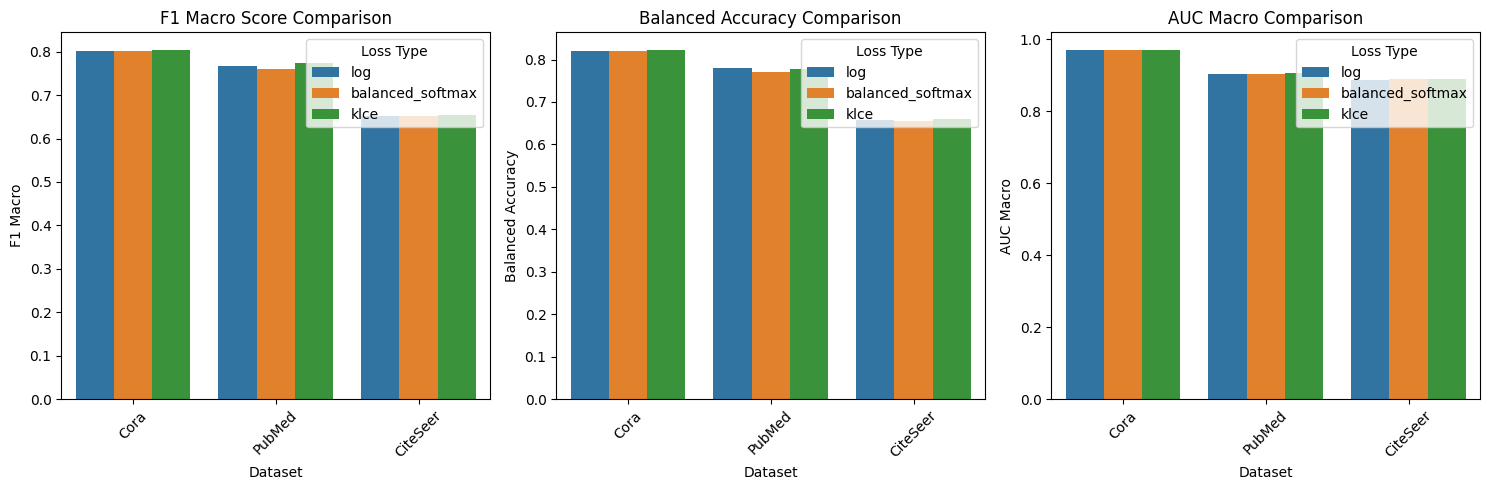

In [ ]:


from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import label_binarize

class BalancedSoftmaxLoss(torch.nn.Module):
    def __init__(self, samples_per_class):
        super().__init__()
        self.samples_per_class = samples_per_class
        self.class_weights = 1.0 / (samples_per_class + 1e-8)
        self.class_weights /= self.class_weights.sum()

    def forward(self, inputs, targets):
        weights = self.class_weights[targets].to(inputs.device)
        loss = F.cross_entropy(inputs, targets, reduction='none')
        weighted_loss = (loss * weights).mean()
        
        return weighted_loss

def klce_loss(p_pred, p_target, baseline_loss, lambda_, lambda_klce):
    p_target = p_target.unsqueeze(0).expand_as(p_pred)
    epsilon = 1e-8
    
    kl_divergence = torch.sum(p_pred * torch.log(p_pred / (p_target + epsilon)), dim=-1)
    cross_entropy = -torch.sum(p_target * torch.log(p_pred + epsilon), dim=-1)
    
    klce = (lambda_klce * cross_entropy) + kl_divergence
    
    return baseline_loss + (lambda_ * (klce.mean()))

def calculate_target_distribution(data, num_classes):
    _, class_counts = torch.unique(data.y[data.train_mask], return_counts=True)
    
    class_ratios = class_counts / class_counts.sum()
    inverse_ratios = 1.0 / (class_ratios)
    p_k = inverse_ratios / inverse_ratios.sum()
    
    return p_k

class GCNNet(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, num_layers):
        super(GCNNet, self).__init__()
        self.layers = torch.nn.ModuleList()
        
        self.layers.append(GCNConv(num_features, hidden_channels))
        
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        
        self.layers.append(GCNConv(hidden_channels, num_classes))
    
    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

def comprehensive_evaluation(y_true, y_pred, y_pred_proba, num_classes):
    """
    Generate a comprehensive set of performance metrics
    """
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    
    # Metrics dictionary to store all results
    metrics = {}
    
    # Classification Report
    metrics['classification_report'] = classification_report(y_true, y_pred, output_dict=True)
    
    # Macro-averaged metrics
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    
    # Balanced Accuracy
    metrics['balanced_accuracy'] = balanced_accuracy_score(y_true, y_pred)
    
    # ROC AUC (One-vs-Rest)
    metrics['auc_macro'] = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')
    
    # Per-class ROC AUC
    metrics['per_class_auc'] = []
    for i in range(num_classes):
        try:
            auc = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
            metrics['per_class_auc'].append(auc)
        except:
            metrics['per_class_auc'].append(None)
    
    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    
    return metrics

def train_and_evaluate(model, data, optimizer, target_distribution, num_classes, 
                       dataset_name, loss_type='log', lambda_=None, lambda_klce=None, 
                       balanced_loss_weights=None):
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        
        if loss_type == 'log':
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        elif loss_type == 'klce':
            baseline_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss = klce_loss(
                torch.exp(out[data.train_mask]),
                target_distribution.to(out.device), 
                baseline_loss, 
                lambda_, 
                lambda_klce
            )
        elif loss_type == 'balanced_softmax':
            criterion = BalancedSoftmaxLoss(balanced_loss_weights)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
        
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        y_true = data.y[data.test_mask].numpy()
        y_pred = pred[data.test_mask].numpy()
        y_pred_proba = out[data.test_mask].softmax(dim=1).numpy()
        
        # Comprehensive evaluation
        metrics = comprehensive_evaluation(y_true, y_pred, y_pred_proba, num_classes)
        metrics['dataset'] = dataset_name
        metrics['loss_type'] = loss_type
        
        return metrics

def main():
    # Predefined lambda parameters from previous results
    lambda_params = {
        'Cora': {'lambda': 0.411822, 'lambda_klce': 0.320919},
        'PubMed': {'lambda': 0.782907, 'lambda_klce': 0.497927},
        'CiteSeer': {'lambda': 0.006151, 'lambda_klce': 0.696084}
    }
    
    # Fixed hyperparameters
    learning_rate = 0.0005692473826048461
    hidden_channels = 128
    num_layers = 1
    
    # Loss types to compare
    loss_types = ['log', 'balanced_softmax', 'klce']
    
    # Detailed results storage
    detailed_results = []
    
    # Iterate through datasets
    for dataset_name in ['Cora', 'PubMed', 'CiteSeer']:
        # Load dataset
        dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, transform=T.NormalizeFeatures())
        
        # Prepare target distribution
        data = dataset[0]
        target_distribution = calculate_target_distribution(data, dataset.num_classes)
        
        # Prepare balanced softmax weights if needed
        _, class_counts = torch.unique(data.y[data.train_mask], return_counts=True)
        balanced_loss_weights = class_counts
        
        # Evaluate each loss type
        for loss_type in loss_types:
            # Create model
            model = GCNNet(dataset.num_features, dataset.num_classes, hidden_channels, num_layers)
            
            # Choose optimizer
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
            
            # Prepare loss-specific parameters
            if loss_type == 'klce':
                lambda_ = lambda_params[dataset_name]['lambda']
                lambda_klce = lambda_params[dataset_name]['lambda_klce']
            else:
                lambda_ = lambda_klce = None
            
            # Train and evaluate
            result = train_and_evaluate(
                model, data, optimizer, target_distribution, dataset.num_classes,
                dataset_name,
                loss_type=loss_type,
                lambda_=lambda_,
                lambda_klce=lambda_klce,
                balanced_loss_weights=balanced_loss_weights
            )
            
            detailed_results.append(result)
    
    # Create summary DataFrame
    summary_data = []
    for result in detailed_results:
        summary_data.append({
            'Dataset': result['dataset'],
            'Loss Type': result['loss_type'],
            'F1 Macro': result['f1_macro'],
            'Balanced Accuracy': result['balanced_accuracy'],
            'AUC Macro': result['auc_macro']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    # F1 Macro Comparison
    plt.subplot(1, 3, 1)
    sns.barplot(x='Dataset', y='F1 Macro', hue='Loss Type', data=summary_df)
    plt.title('F1 Macro Score Comparison')
    plt.xticks(rotation=45)
    
    # Balanced Accuracy Comparison
    plt.subplot(1, 3, 2)
    sns.barplot(x='Dataset', y='Balanced Accuracy', hue='Loss Type', data=summary_df)
    plt.title('Balanced Accuracy Comparison')
    plt.xticks(rotation=45)
    
    # AUC Macro Comparison
    plt.subplot(1, 3, 3)
    sns.barplot(x='Dataset', y='AUC Macro', hue='Loss Type', data=summary_df)
    plt.title('AUC Macro Comparison')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('results/loss_comparison.png')
    
    # Save detailed and summary results
    os.makedirs('results', exist_ok=True)
    summary_df.to_csv('results/loss_comparison_summary.csv', index=False)
    
    with open('results/loss_comparison_details.txt', 'w') as f:
        for result in detailed_results:
            f.write(f"Dataset: {result['dataset']}, Loss Type: {result['loss_type']}\n")
            f.write(f"Classification Report:\n{pd.DataFrame(result['classification_report']).transpose()}\n")
            f.write(f"Confusion Matrix:\n{result['confusion_matrix']}\n\n")
    
    print("Comparison complete. Results saved in 'results' directory.")
    print("\nSummary DataFrame:")
    print(summary_df)

if __name__ == "__main__":
    main()

In [ ]:
summary_df = pd.read_csv('results/loss_comparison_summary.csv')
summary_df

,Dataset,Loss Type,F1 Macro,Balanced Accuracy,AUC Macro
0,Cora,log,0.801788,0.820512,0.970880
1,Cora,balanced_softmax,0.801162,0.819746,0.970603
2,Cora,klce,0.804529,0.822907,0.969988
3,PubMed,log,0.767681,0.779221,0.904149
4,PubMed,balanced_softmax,0.760896,0.771708,0.903261
5,PubMed,klce,0.773861,0.778104,0.905461
6,CiteSeer,log,0.651616,0.656630,0.888273
7,CiteSeer,balanced_softmax,0.651797,0.655563,0.888538
8,CiteSeer,klce,0.654567,0.659160,0.889915


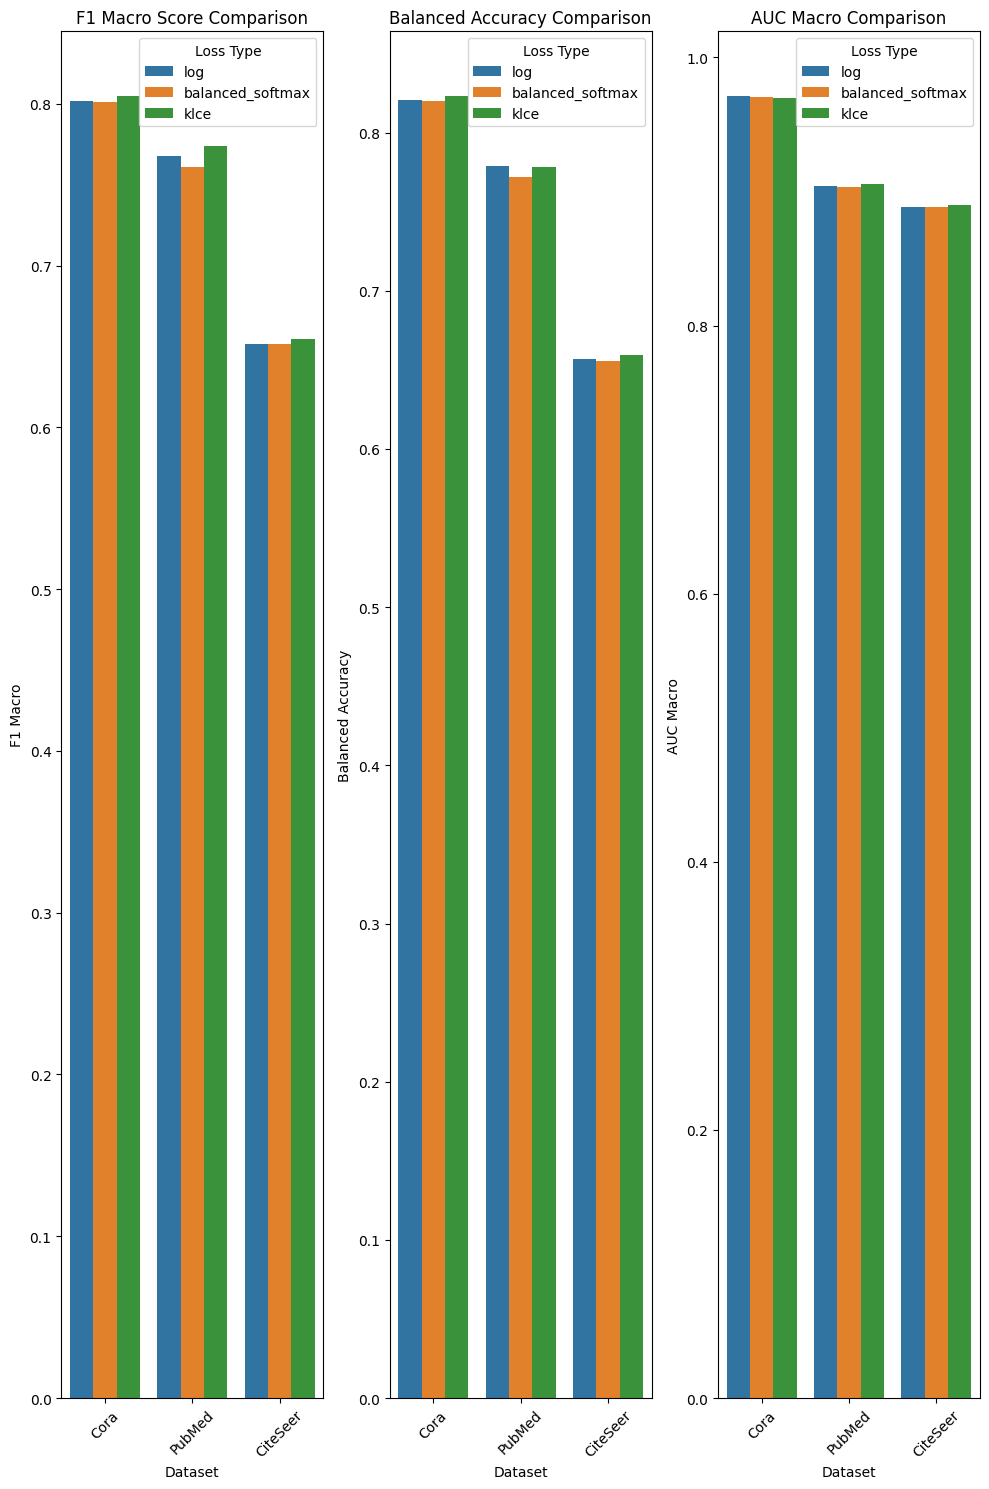

In [ ]:
# Visualize results
plt.figure(figsize=(10, 15))

# F1 Macro Comparison
plt.subplot(1, 3, 1)
sns.barplot(x='Dataset', y='F1 Macro', hue='Loss Type', data=summary_df)
plt.title('F1 Macro Score Comparison')
plt.xticks(rotation=45)

# Balanced Accuracy Comparison
plt.subplot(1, 3, 2)
sns.barplot(x='Dataset', y='Balanced Accuracy', hue='Loss Type', data=summary_df)
plt.title('Balanced Accuracy Comparison')
plt.xticks(rotation=45)

# AUC Macro Comparison
plt.subplot(1, 3, 3)
sns.barplot(x='Dataset', y='AUC Macro', hue='Loss Type', data=summary_df)
plt.title('AUC Macro Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
# plt.savefig('results/loss_comparison.png')